## 5) Feature Engineering

### 5) a)Feature Transformation
######   Handling categorical outliers
######   Handling outliers
######   Handling Null values
######   Feature scaling and normal transformation
### 5) b)Feature construction
### 5) c)Feature extraction
#### 5) d)Feature Selection

In [1]:
import numpy as np
import pandas as pd
import copy
import random
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import  mean_absolute_error,mean_squared_error,r2_score

In [2]:
df = pd.read_csv('data/concrete_data.csv')

### Splitting the data

In [3]:
train_data,test_data = train_test_split(df, test_size=0.33, random_state=42)

In [4]:
#train_data.to_csv('data/train_data.csv',index=False)
#test_data.to_csv('data/test_data.csv',index = False)

### Reading training data

In [5]:
df = pd.read_csv('data/train_data.csv')

In [6]:
initial_observations = df.shape[0]

In [7]:
#Handling null values
df.isna().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

In [8]:
#Handling outliers

In [9]:
df.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate ', 'age',
       'concrete_compressive_strength'],
      dtype='object')

In [10]:
def outliers_detection(df : pd.DataFrame,col):
    IQR = np.round(np.abs(df[col].quantile(0.75) - df[col].quantile(0.25)),3)
    lower_limit = np.round(df[col].quantile(0.25) - (1.5*IQR),3)
    higher_limit = np.round(df[col].quantile(0.75) + (1.5*IQR),3)
    return IQR,lower_limit,higher_limit

In [11]:
for col in df.columns[:-1]:
    IQR,lower_limit,higher_limit = outliers_detection(df,col)
    df = df[(lower_limit <= df[col]) & (df[col] <= higher_limit)].copy()

In [12]:
df.shape

(631, 9)

In [13]:
print(f'Amount of observations lost after handling outliers : {round(100 - (df.shape[0]/initial_observations)*100,3)}%')
print(f"The number of observations lost after handling outliers : {initial_observations-df.shape[0]} out of {initial_observations}")

Amount of observations lost after handling outliers : 8.551%
The number of observations lost after handling outliers : 59 out of 690


In [14]:
test_data.shape

(340, 9)

In [15]:
for col in test_data.columns[:-1]:
    IQR,lower_limit,higher_limit = outliers_detection(df,col)
    test_data = test_data[(lower_limit <= test_data[col]) & (test_data[col] <= higher_limit)].copy()

In [16]:
test_data.shape

(268, 9)

### Model training, basline reference

In [17]:
models = {'Linear Regression' : LinearRegression(),
          'Ridge Regression' : Ridge(),
          'Lasso Regression' : Lasso(),
          'Decision tree Regression' : DecisionTreeRegressor(),
          'SVM Regression' : SVR(),
          'KNN Regression' : KNeighborsRegressor(),
          'Random Forest Regression' : RandomForestRegressor(),
          'AdaBoost Regression' : AdaBoostRegressor(),
          'GradientBoosting Regression' : GradientBoostingRegressor(),
          'XGB Regression' : XGBRegressor()}

In [18]:
def metrics(y_true, pred, features, irrelavent : int = 0):
    metrics_dict = {}
    mae = mean_absolute_error(y_true=y_true,y_pred=pred)
    mse = mean_squared_error(y_true=y_true,y_pred=pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true,y_pred=pred)
    adjusted_r2 = (1 - ((1-r2)*(features - 1))/(features-irrelavent-1))
    metrics_dict['mae'] = mae
    metrics_dict['mse'] = mse
    metrics_dict['rmse'] = rmse
    metrics_dict['r2'] = r2
    metrics_dict['adjusted_r2'] = adjusted_r2
    return metrics_dict


In [19]:
df.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate ', 'age',
       'concrete_compressive_strength'],
      dtype='object')

In [20]:
train_X = df.drop(['concrete_compressive_strength'], axis = 1).copy()
train_y = df['concrete_compressive_strength']

In [21]:
train_X.shape

(631, 8)

In [22]:
test_X = test_data.drop(['concrete_compressive_strength'], axis = 1).copy()
test_y = test_data['concrete_compressive_strength']

In [23]:
column_transformer_1 = ColumnTransformer([('StandaradScalar', StandardScaler(),[i for i in range(0,8)]),
                                          ('Power transformer', PowerTransformer(), [i for i in range(0,8)])],
                                          remainder='passthrough')

In [24]:
model_performance = {'model_name' : [],
                     'mae' :[],
                     'mse' : [],
                     'rmse' : [],
                     'r2' : [],
                     'adjusted_r2' : []}
for item in models.items():
    name,model = item
    pipeline = Pipeline([('ct_1',column_transformer_1),
                     (name,model)])
    pipeline.fit(train_X,train_y)
    pred = pipeline.predict(test_X)
    metrics_dict = (metrics(test_y,pred,features=8,irrelavent=0))
    model_performance['model_name'].append(name)
    model_performance['mae'].append(metrics_dict['mae'])
    model_performance['mse'].append(metrics_dict['mse'])
    model_performance['rmse'].append(metrics_dict['rmse'])
    model_performance['r2'].append(metrics_dict['r2'])
    model_performance['adjusted_r2'].append(metrics_dict['adjusted_r2'])

In [25]:
model_performance_df_base = pd.DataFrame(model_performance)

In [26]:
def metrics_plotter(dataframe: pd.DataFrame, col: str):
    dataframe = dataframe.sort_values(col).copy()
    plt.figure(figsize=(15,7),dpi = 200)
    ax = sns.barplot(data=dataframe, x='model_name', y=col)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
    plt.xticks(rotation=45)


In [27]:
model_performance_df_base.shape

(10, 6)

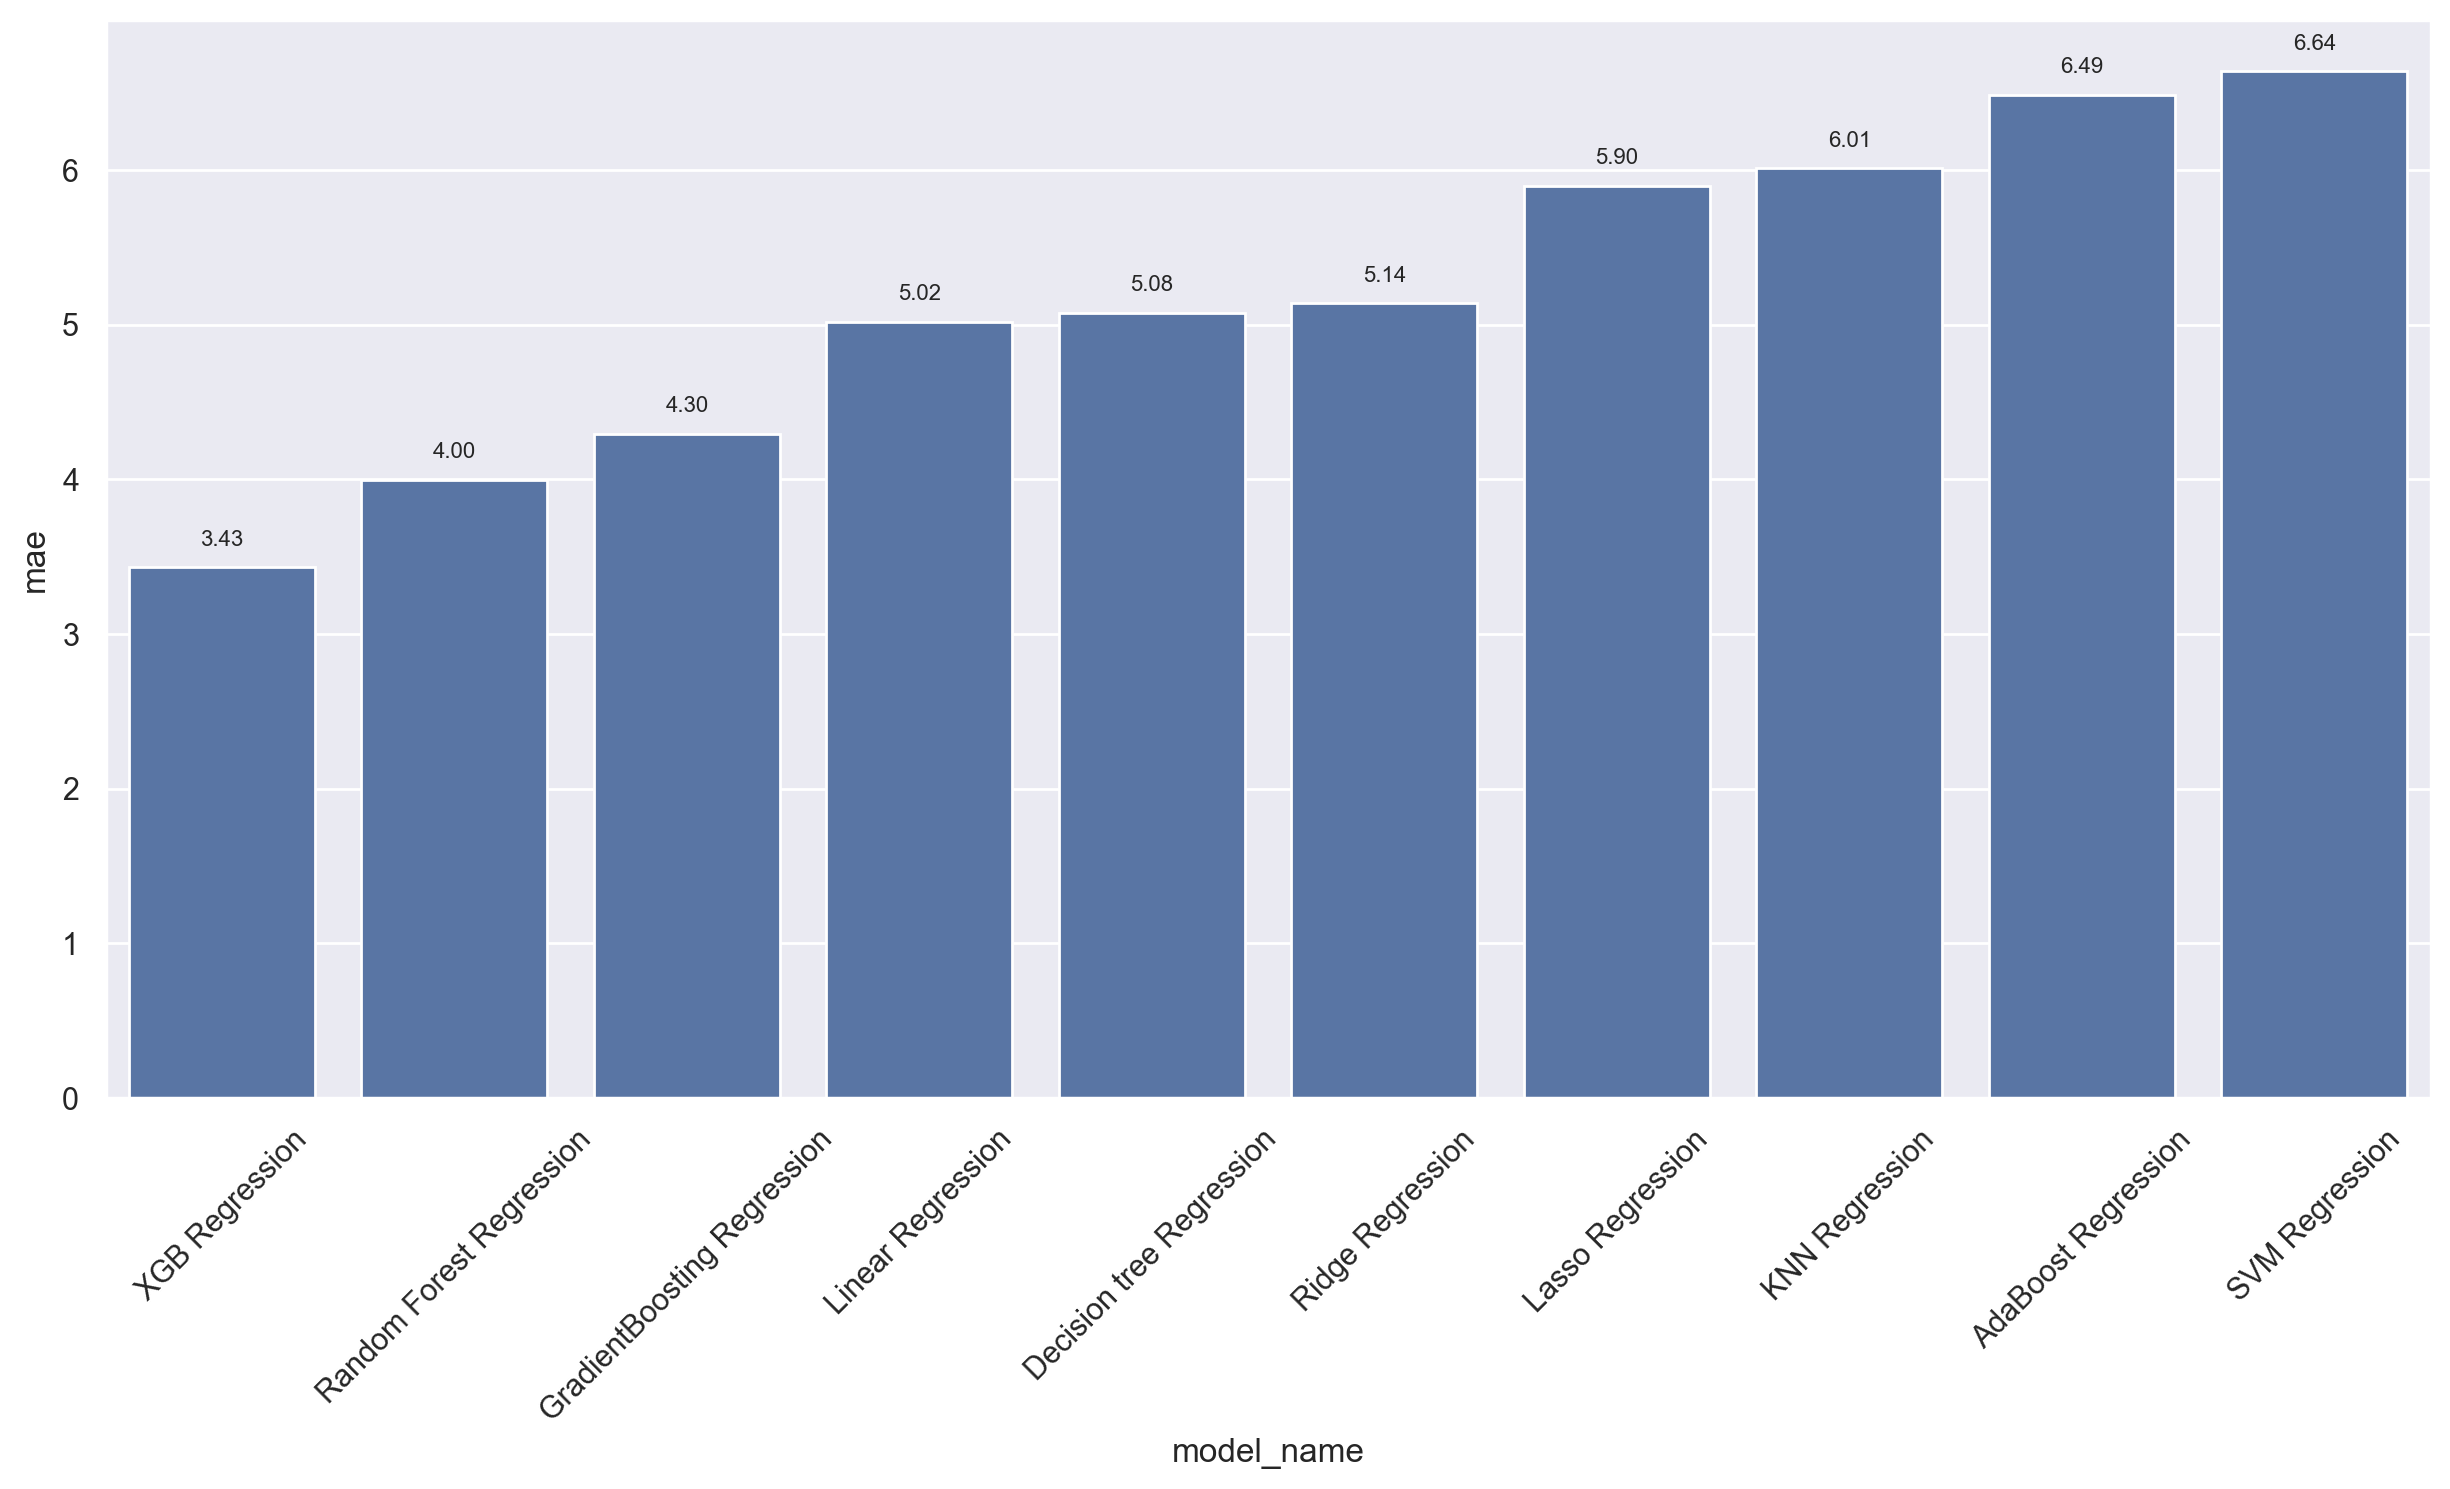

In [28]:
metrics_plotter(dataframe=model_performance_df_base,col = 'mae')

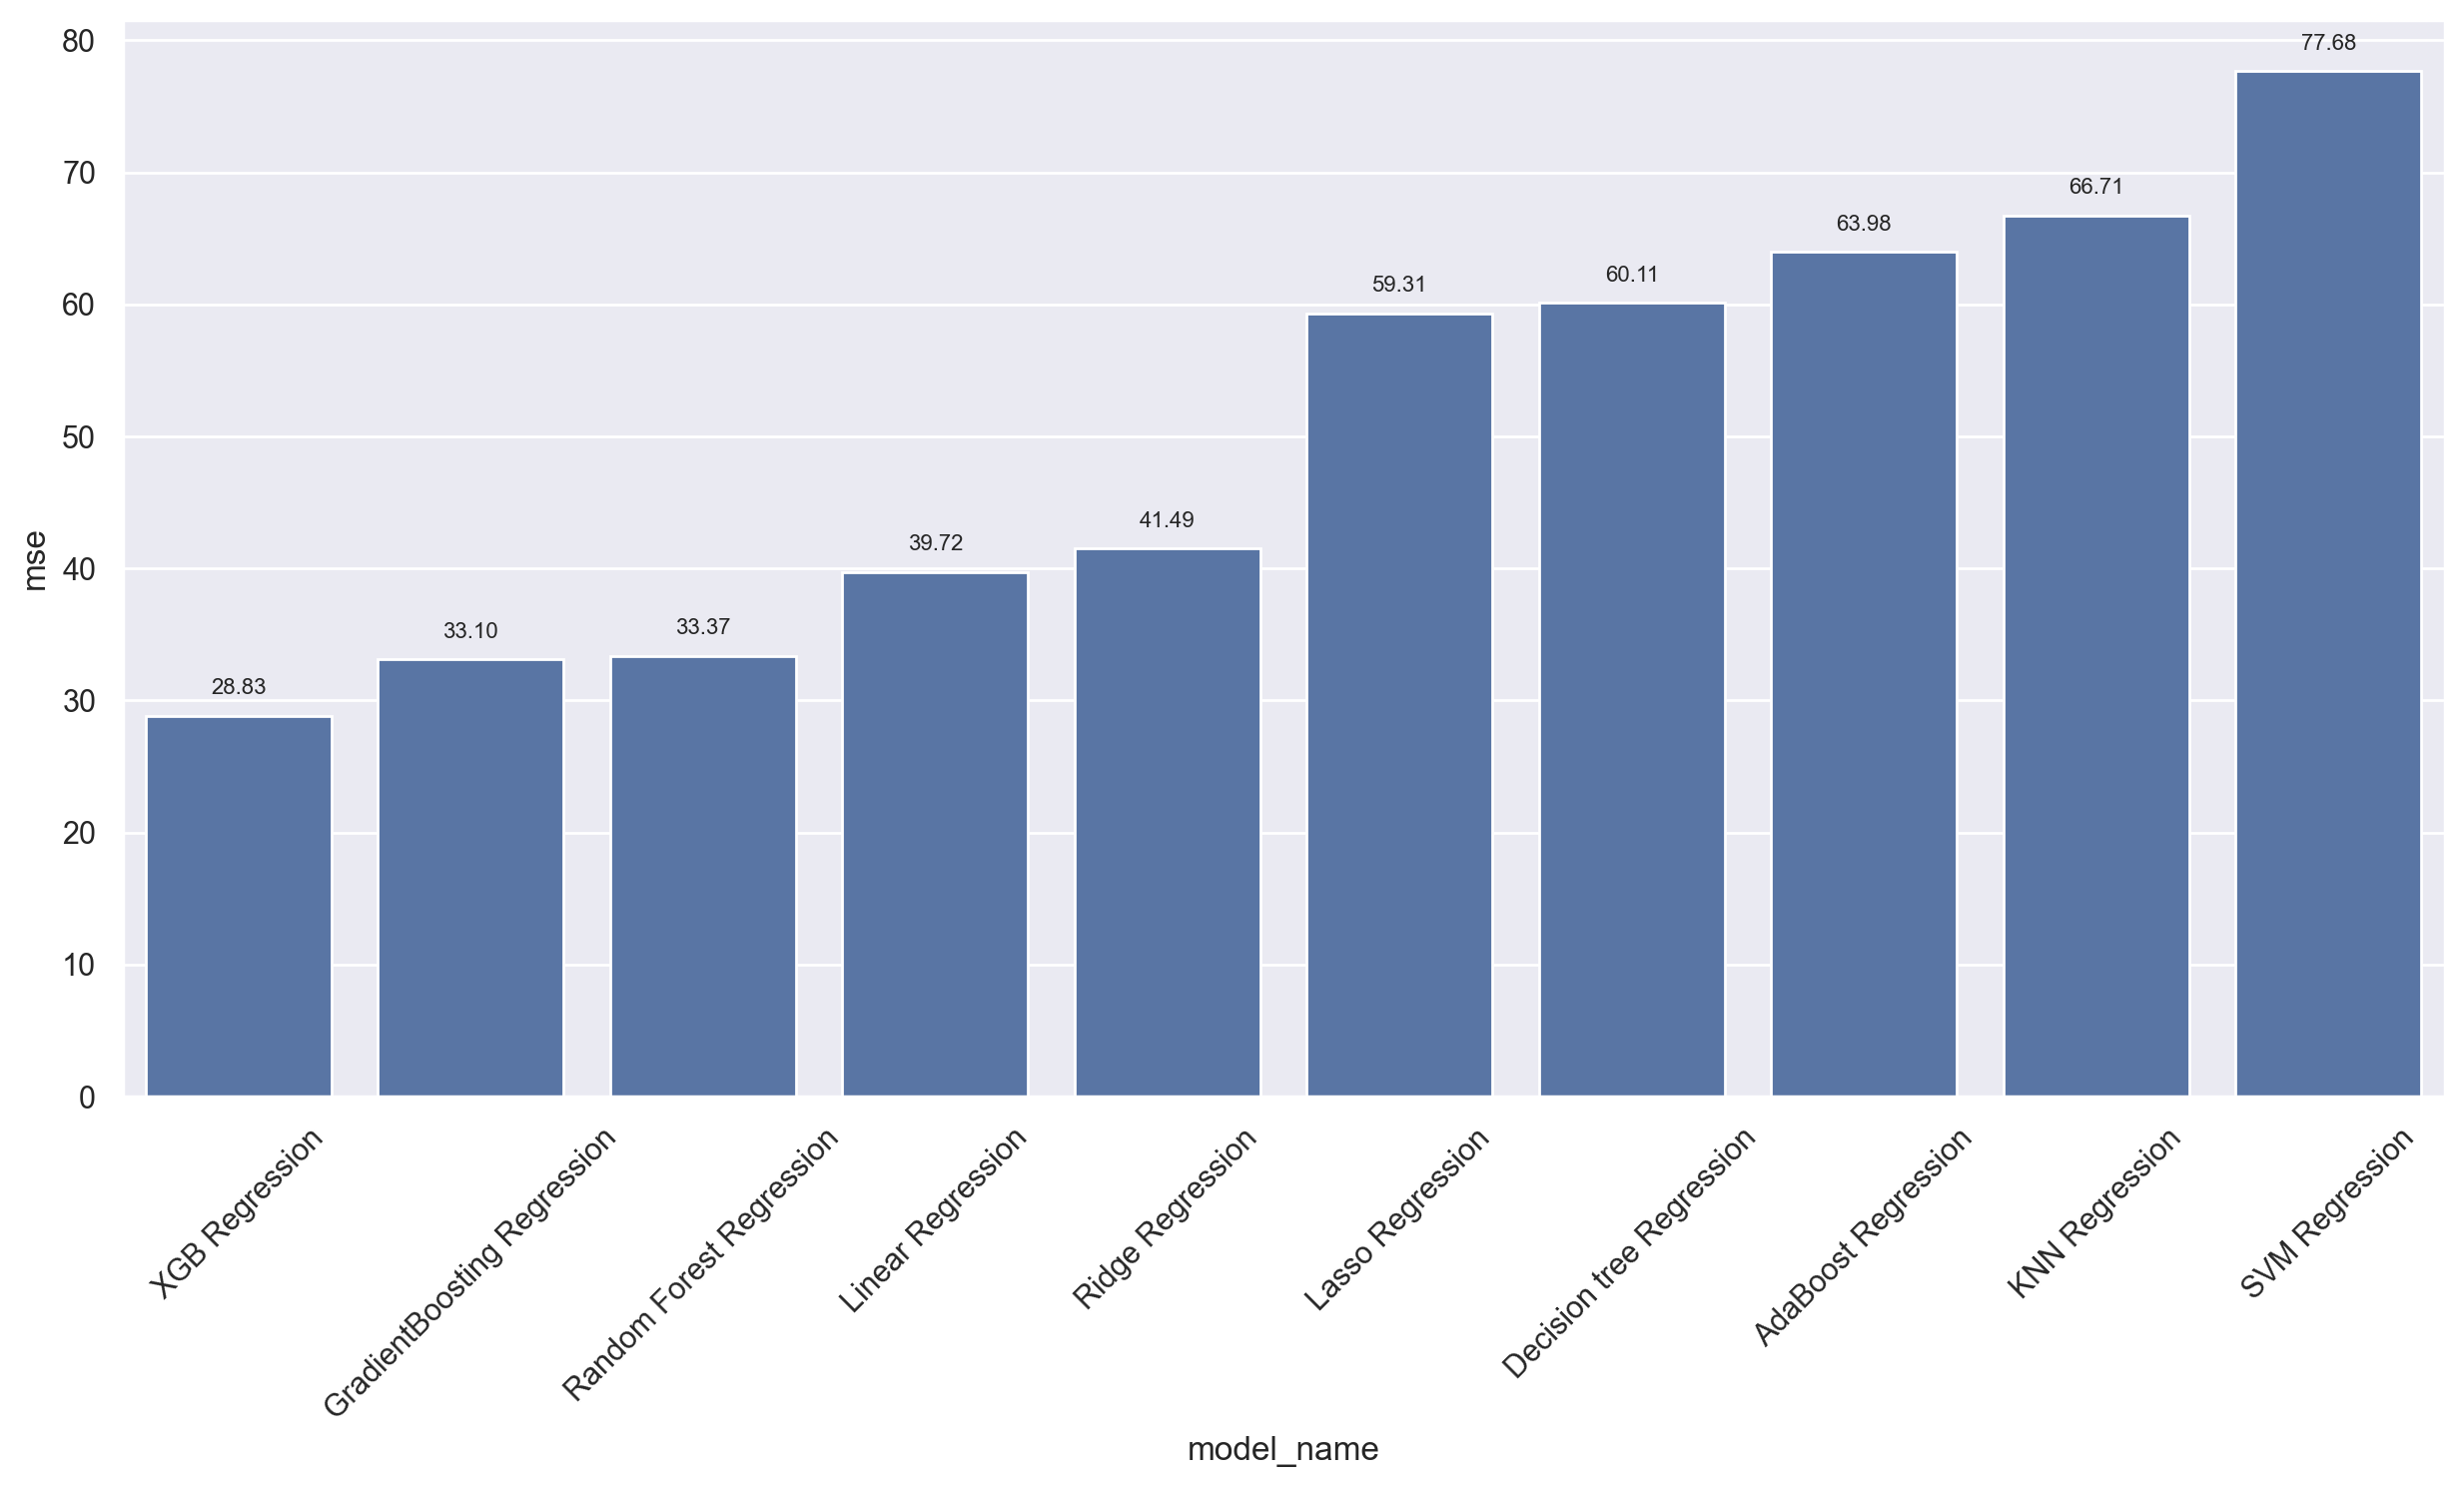

In [29]:
metrics_plotter(dataframe=model_performance_df_base,col = 'mse')

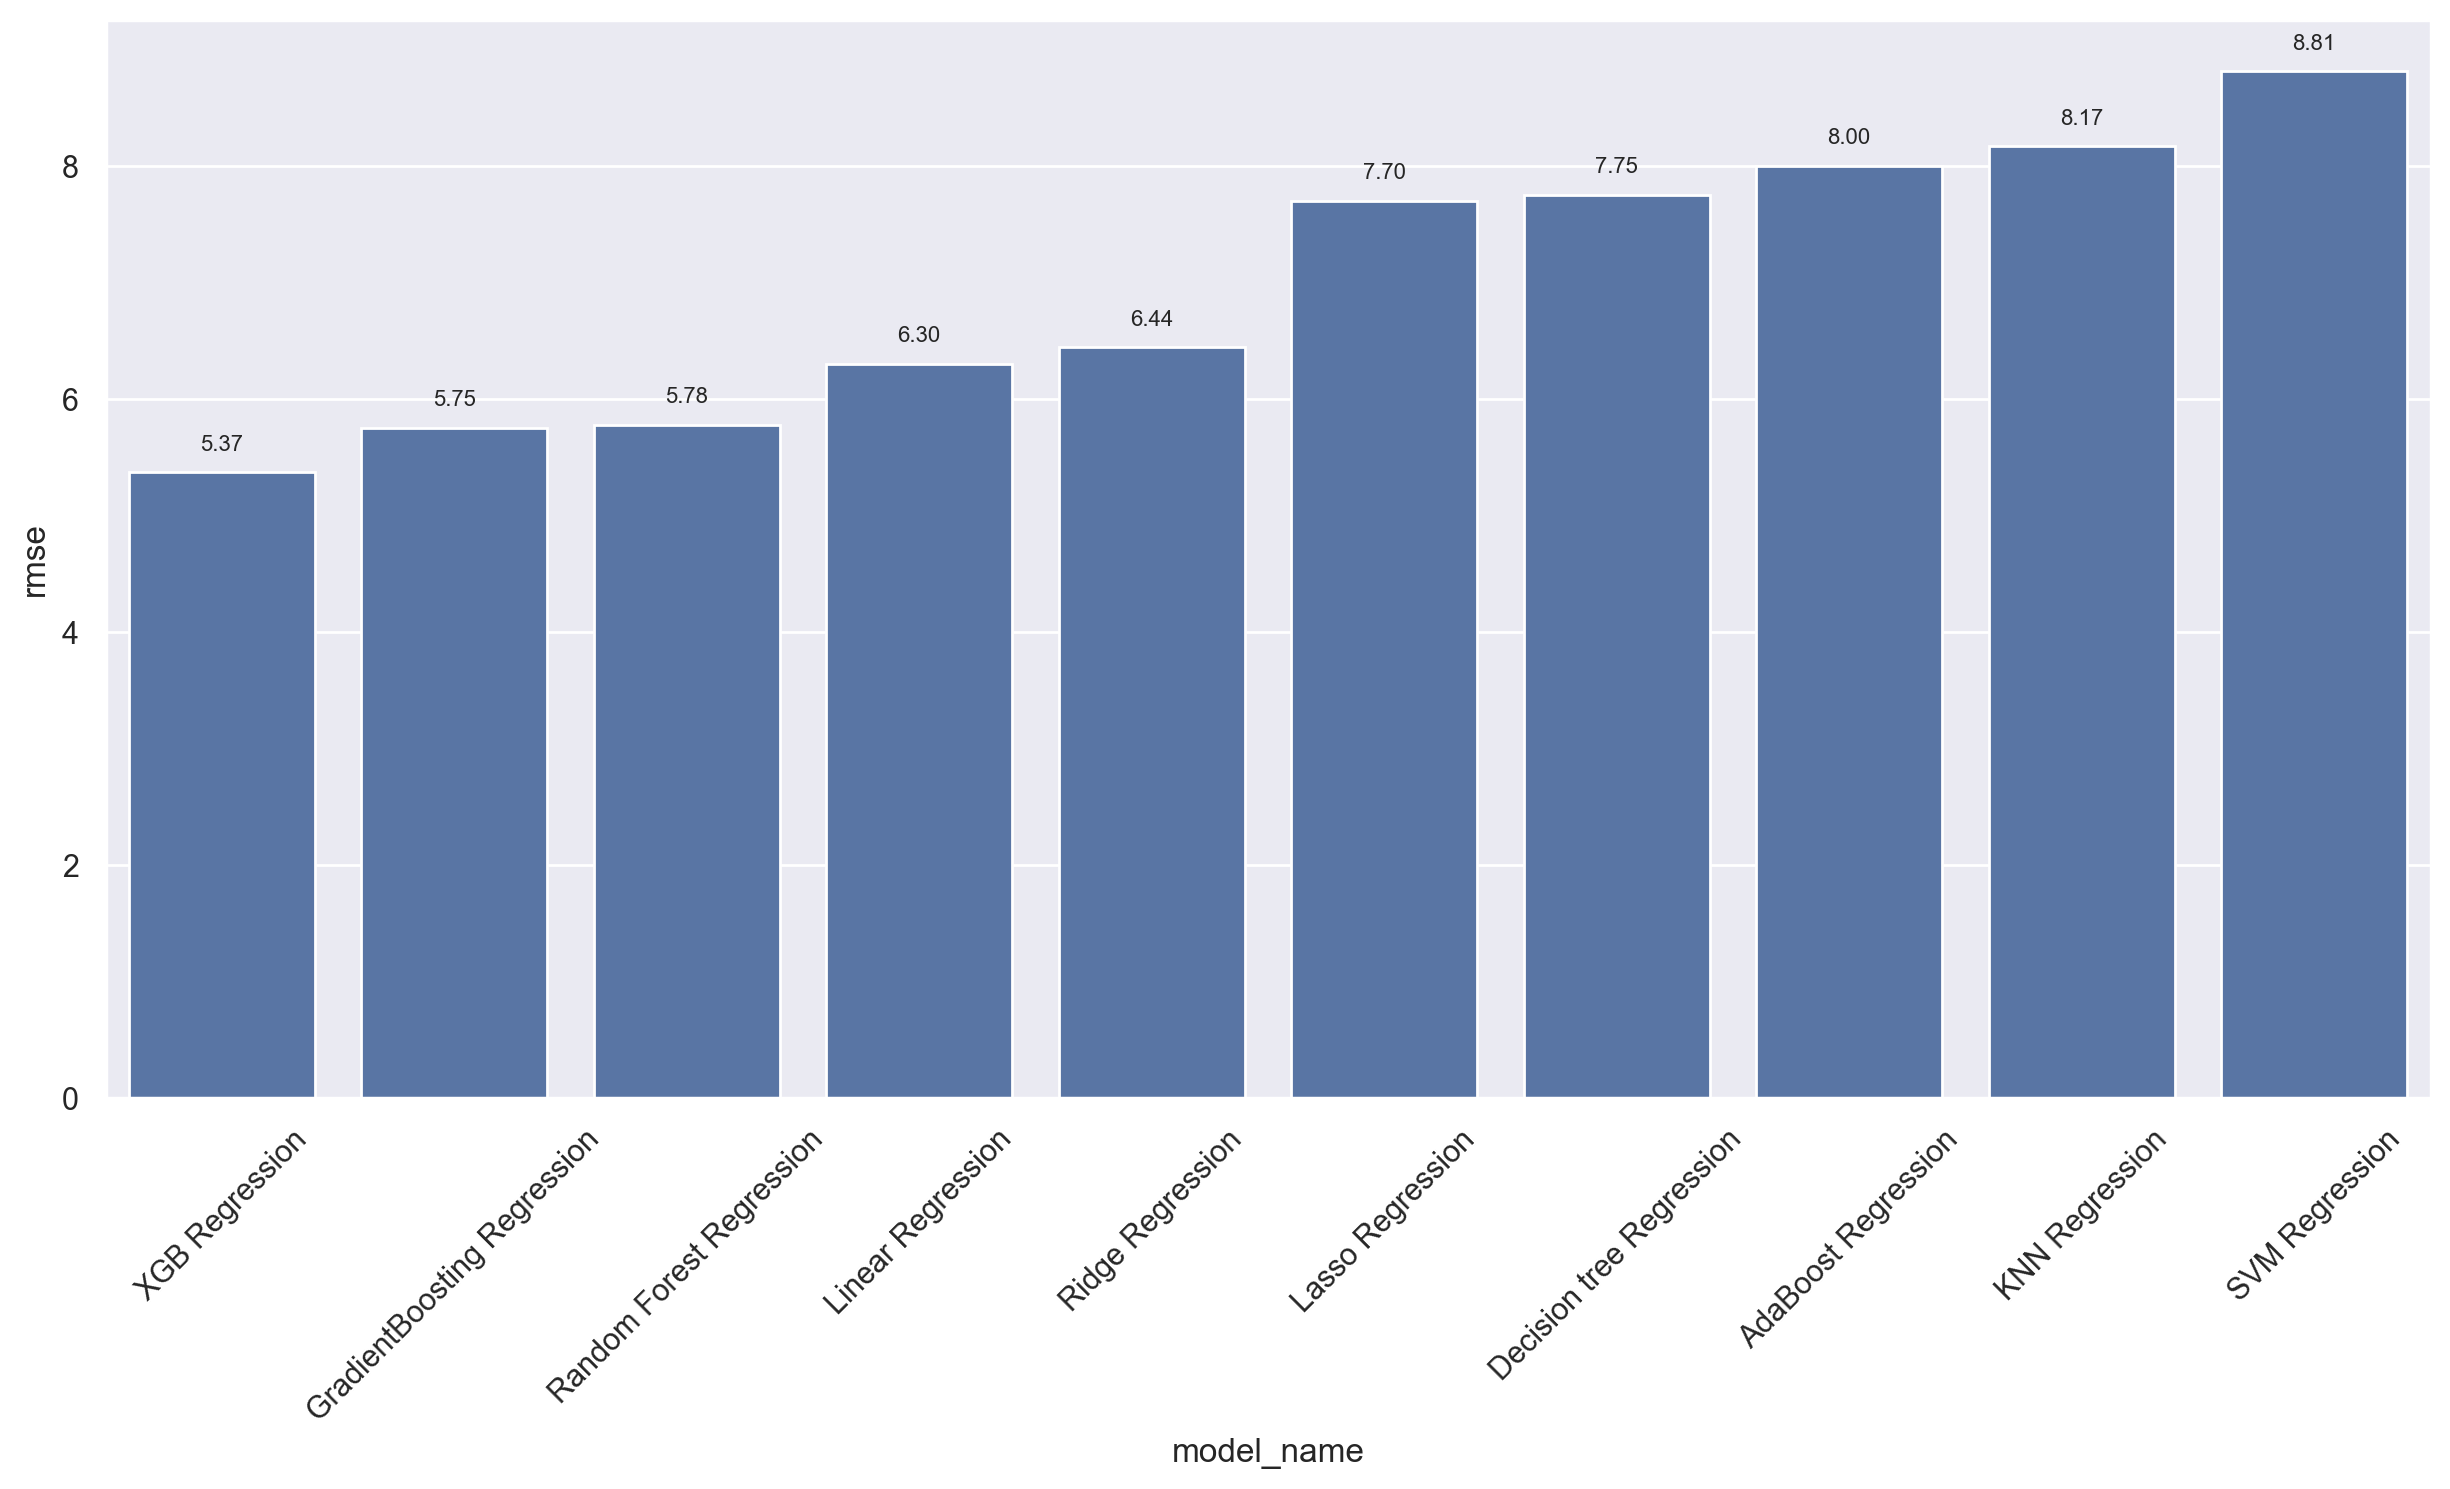

In [30]:
metrics_plotter(dataframe=model_performance_df_base,col = 'rmse')

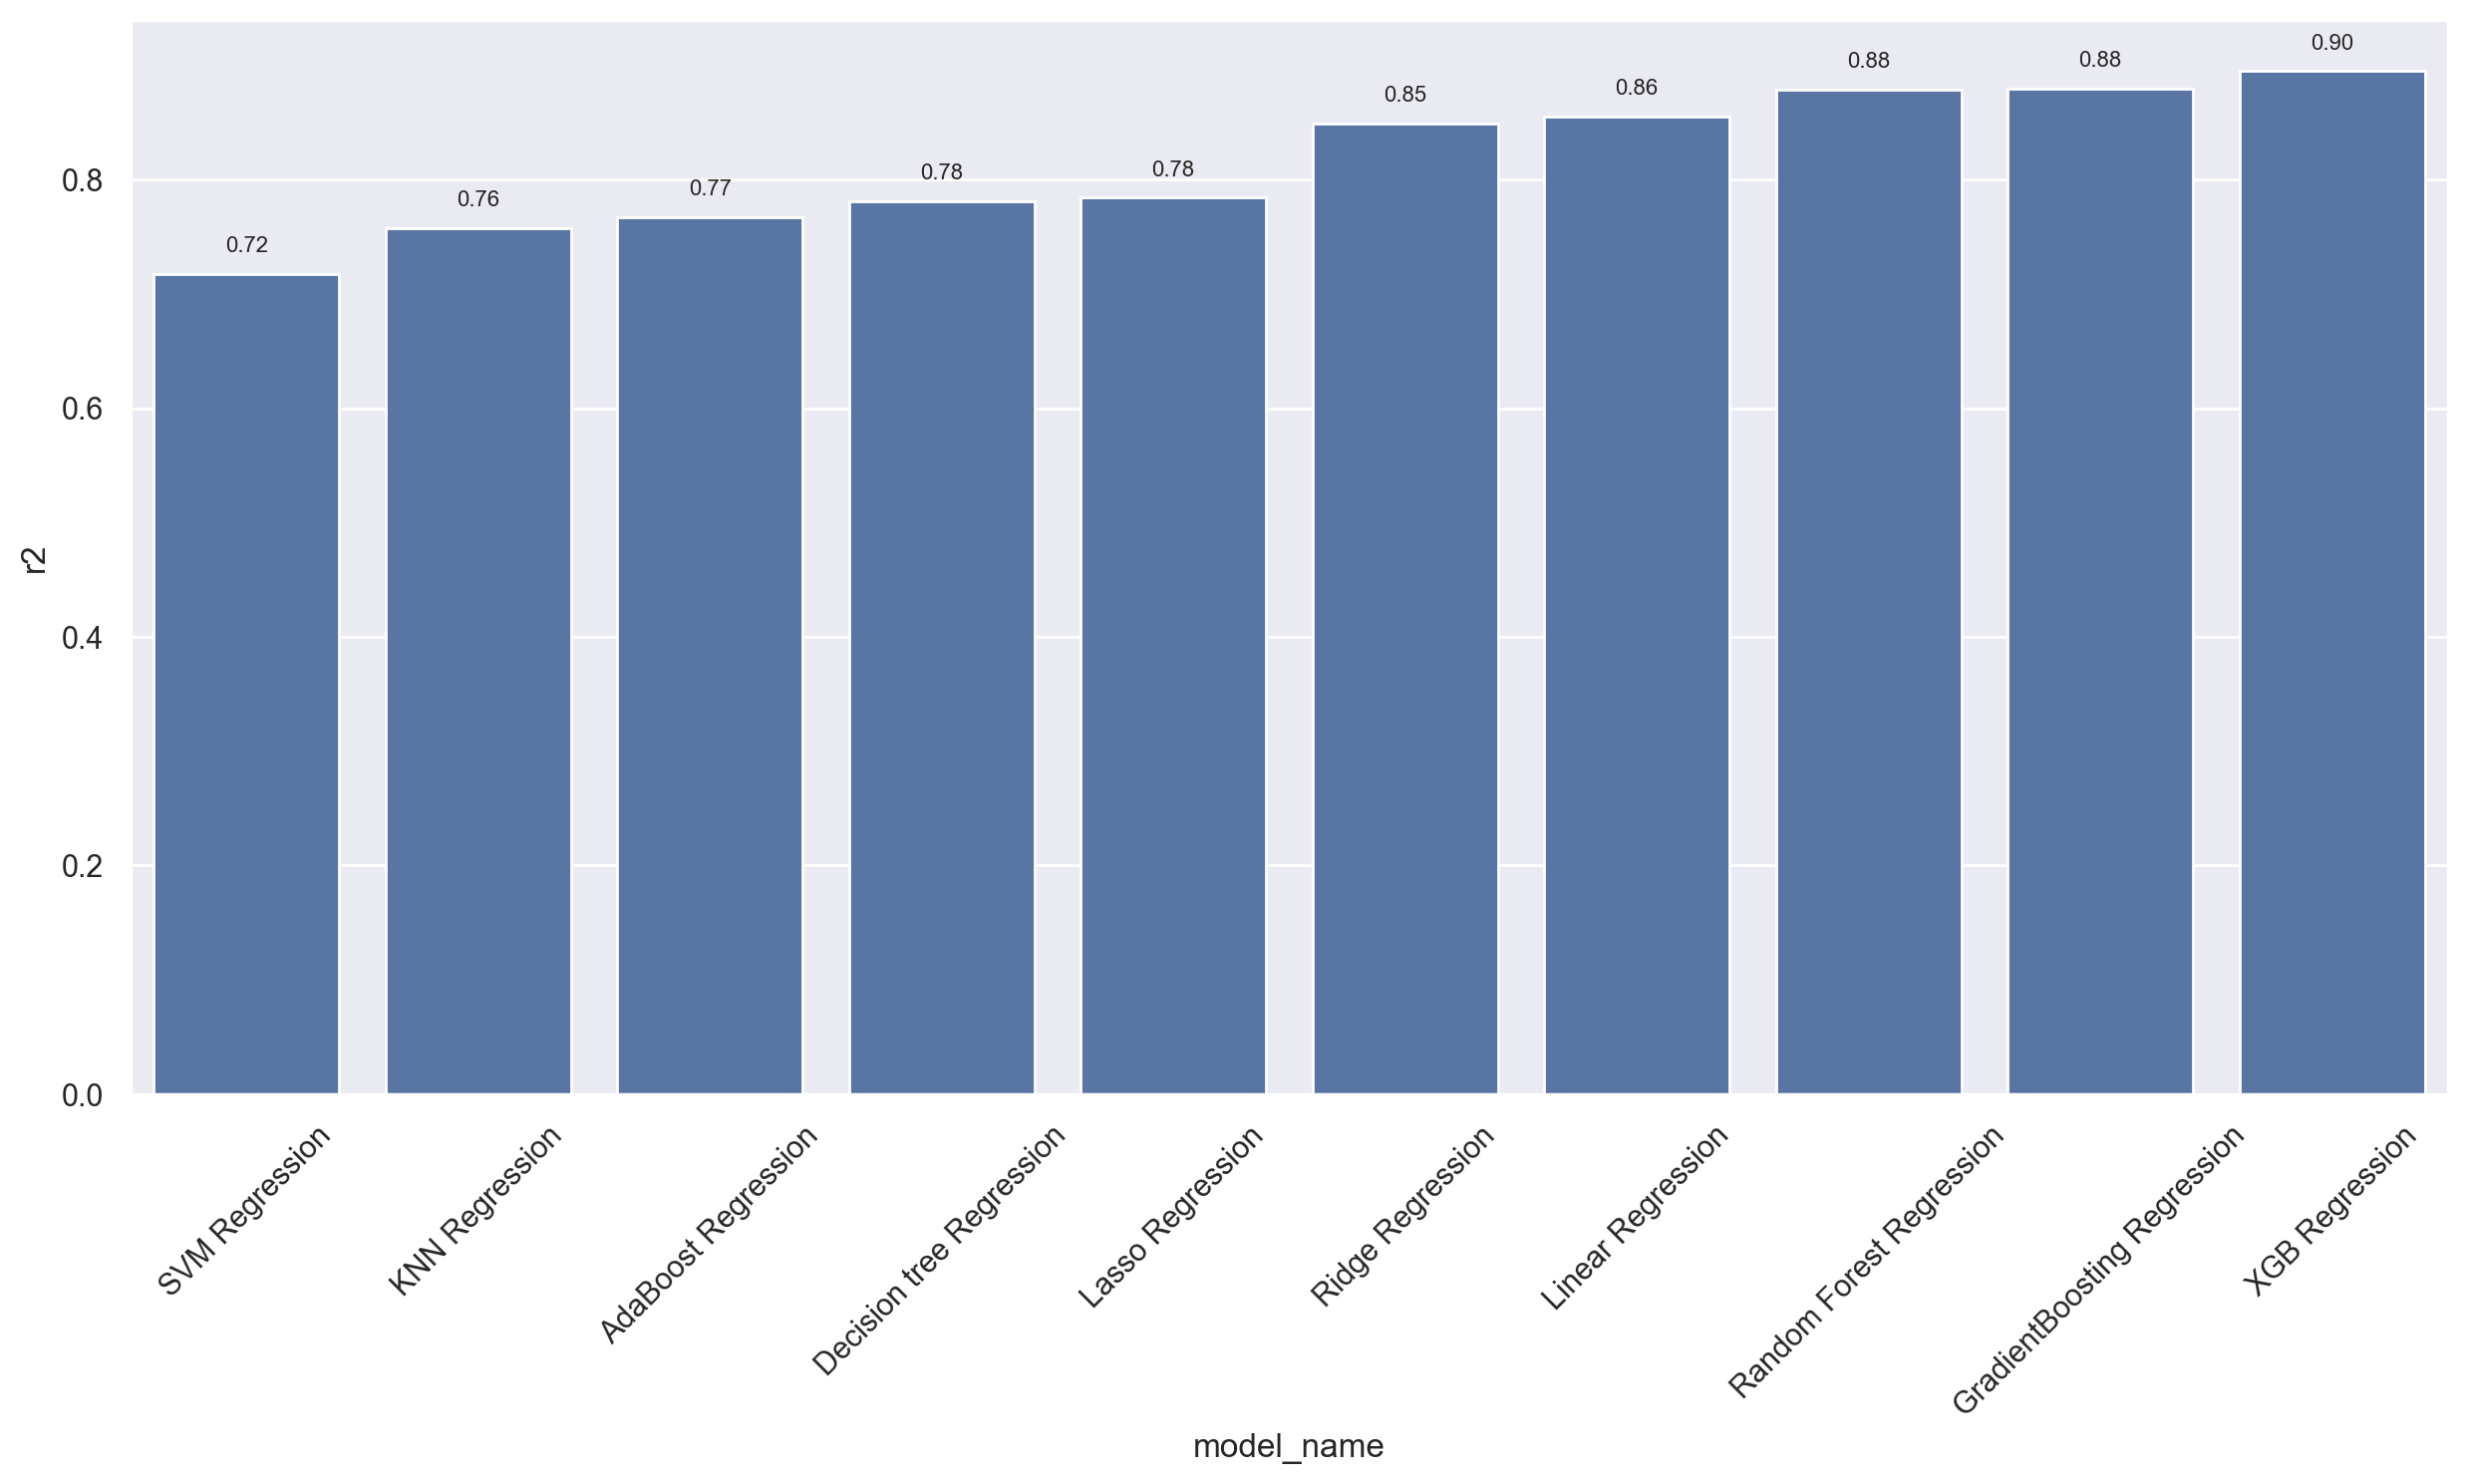

In [31]:
metrics_plotter(dataframe=model_performance_df_base,col = 'r2')

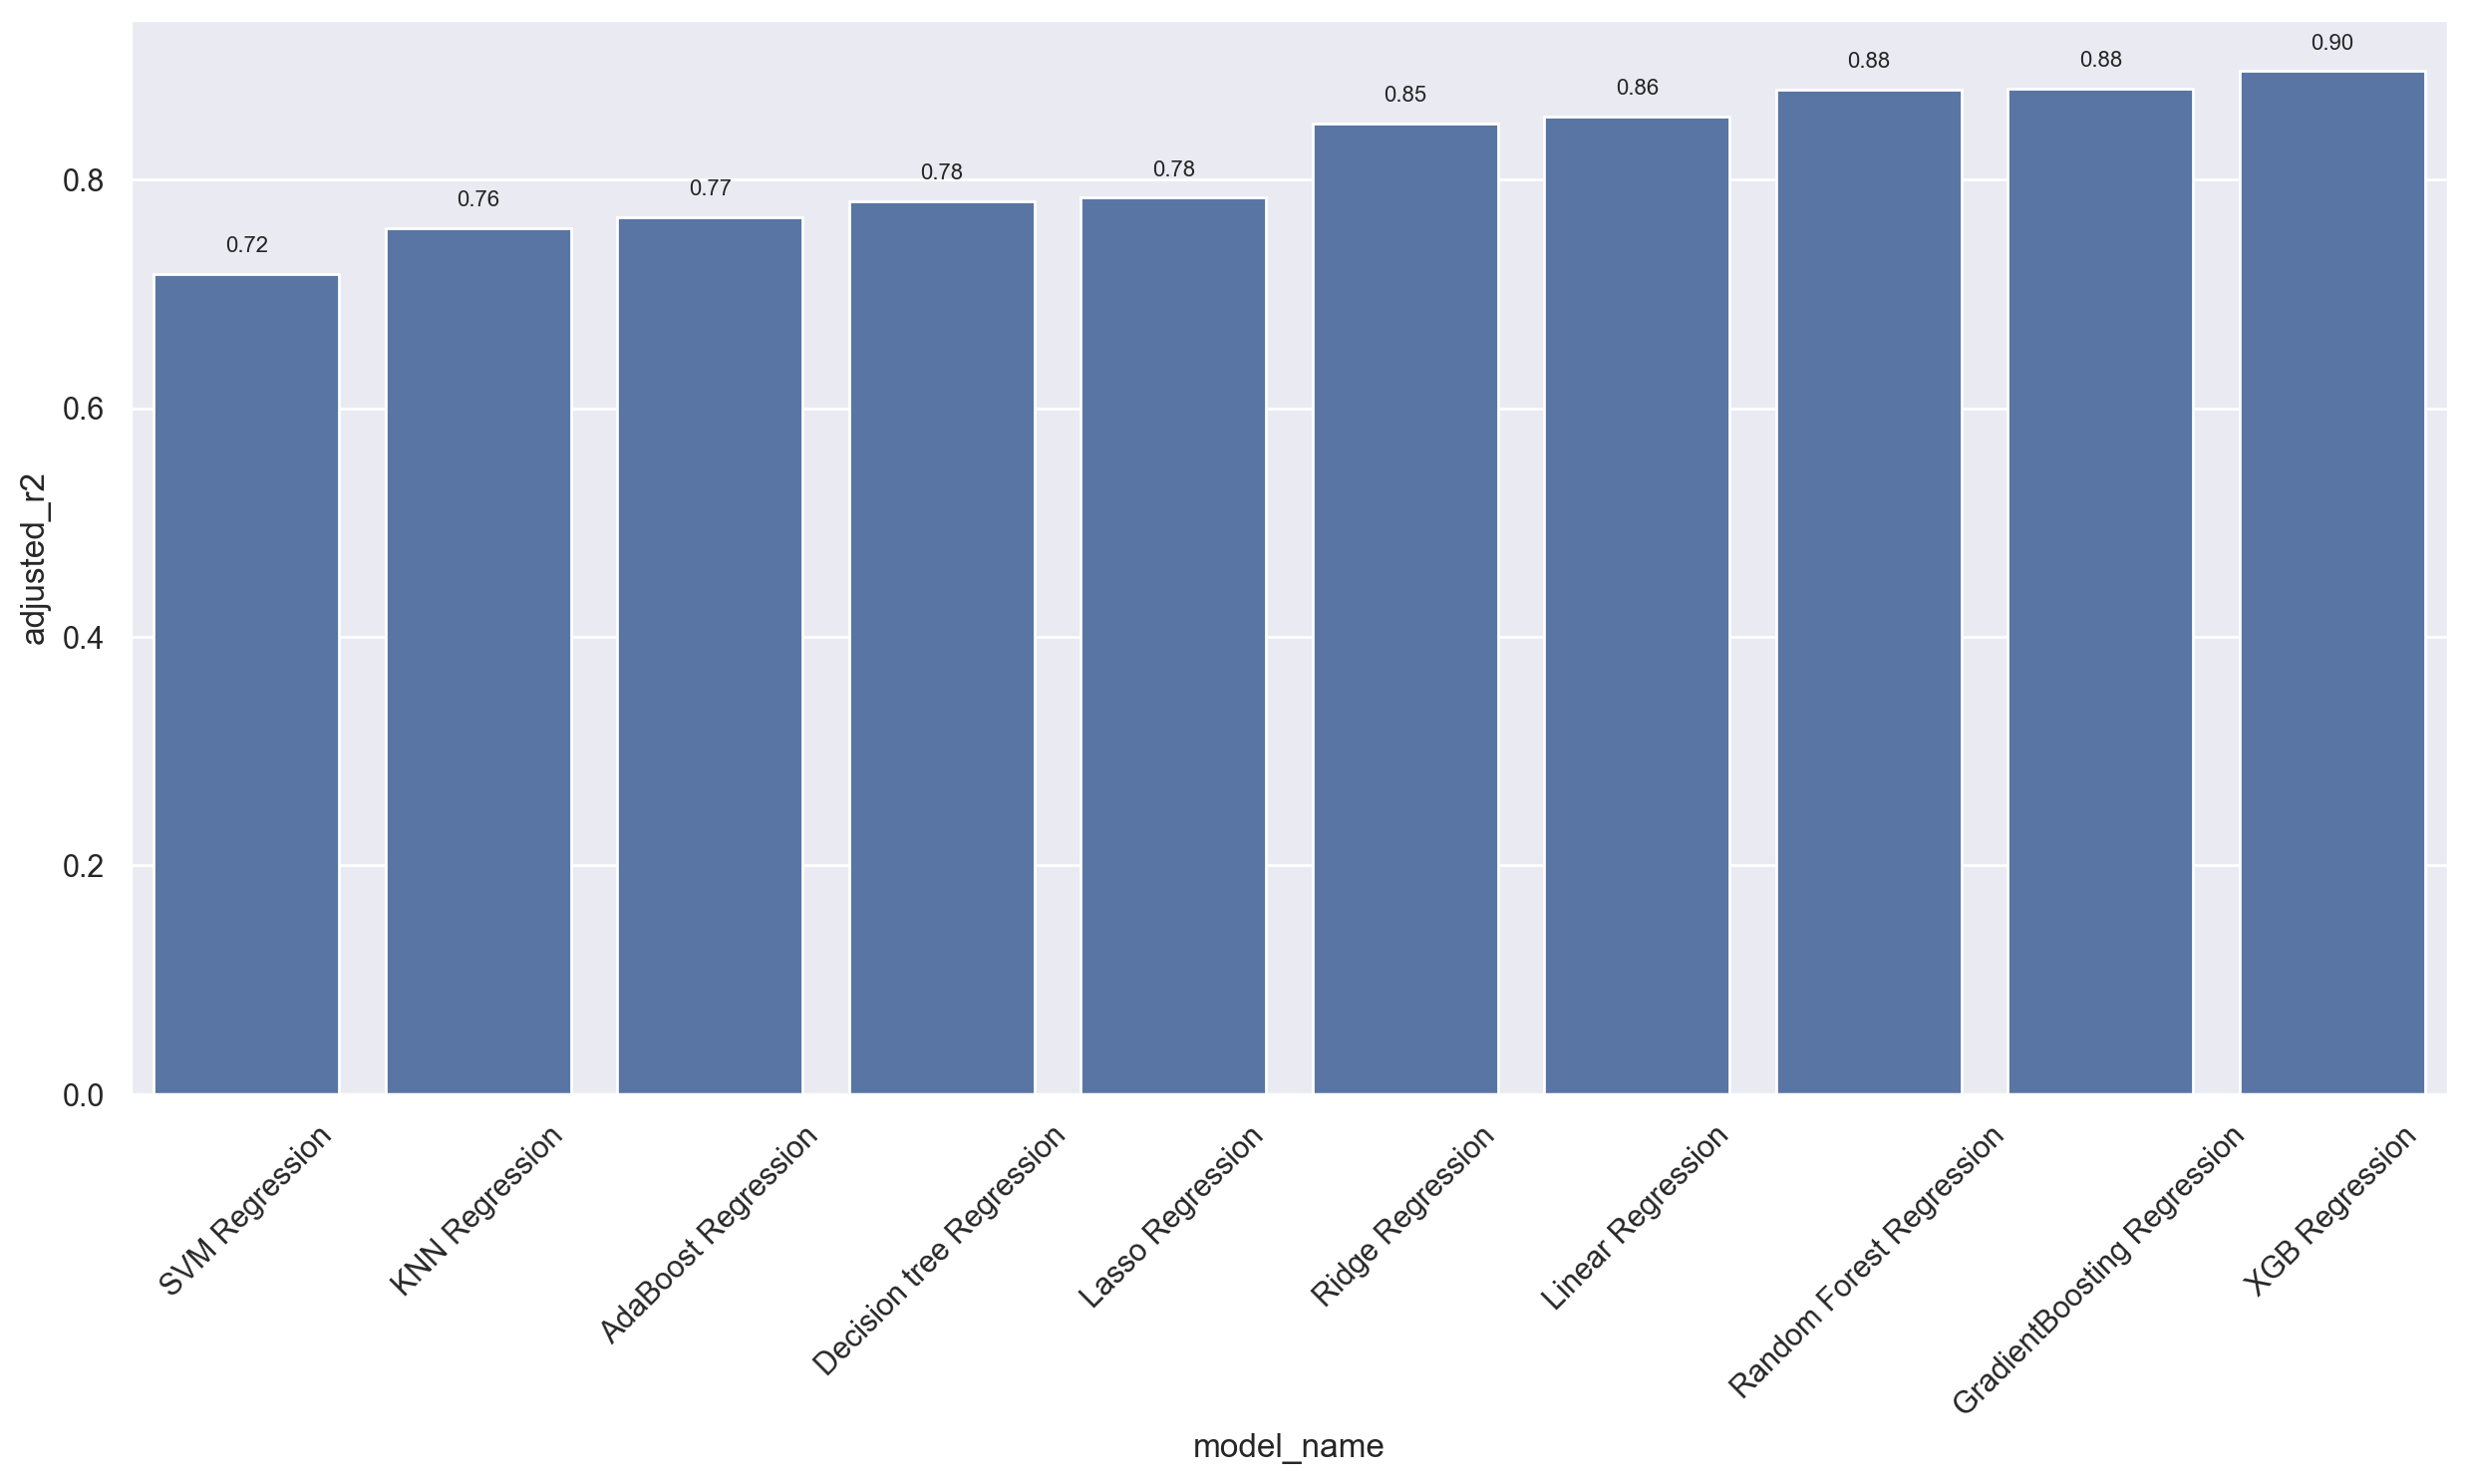

In [32]:
metrics_plotter(dataframe=model_performance_df_base,col = 'adjusted_r2')

## Hyper parameter tuning

In [33]:
param_grid = {
    'Linear Regression': {},
    
    'Ridge Regression': {
        'Ridge Regression__alpha': [0.1, 1, 10]
    },
    
    'Lasso Regression': {
        'Lasso Regression__alpha': [0.1, 1, 10]
    },
    
    'Decision tree Regression': {
        'Decision tree Regression__max_depth': [None, 10, 20],
        'Decision tree Regression__min_samples_split': [2, 5, 10]
    },
    
    'SVM Regression': {
        'SVM Regression__C': [0.1, 1, 10],
        'SVM Regression__kernel': ['linear', 'rbf']
    },
    
    'KNN Regression': {
        'KNN Regression__n_neighbors': [3, 5, 7],
        'KNN Regression__weights': ['uniform', 'distance']
    },
    
    'Random Forest Regression': {
        'Random Forest Regression__n_estimators': [50, 100, 200],
        'Random Forest Regression__max_depth': [None, 10, 20],
        'Random Forest Regression__min_samples_split': [2, 5, 10]
    },
    
    'AdaBoost Regression': {
        'AdaBoost Regression__n_estimators': [50, 100, 200],
        'AdaBoost Regression__learning_rate': [0.01, 0.1, 1]
    },
    
    'GradientBoosting Regression': {
        'GradientBoosting Regression__n_estimators': [50, 100, 200],
        'GradientBoosting Regression__learning_rate': [0.01, 0.1, 1],
        'GradientBoosting Regression__max_depth': [3, 5, 10]
    },
    
    'XGB Regression': {
        'XGB Regression__n_estimators': [50, 100, 200],
        'XGB Regression__learning_rate': [0.01, 0.1, 1],
        'XGB Regression__max_depth': [3, 5, 10]
    }
}

In [34]:
column_transformer_1 = ColumnTransformer([('StandaradScalar', StandardScaler(),[i for i in range(0,8)]),
                                          ('Power transformer', PowerTransformer(), [i for i in range(0,8)])],
                                          remainder='passthrough')

In [35]:
model_performance = {'model_name' : [],
                     'model' : [],
                     'mae' :[],
                     'mse' : [],
                     'rmse' : [],
                     'r2' : [],
                     'adjusted_r2' : []}
for item in tqdm(models.items()):
    name,model = item
    pipeline = Pipeline([('ct_1',column_transformer_1),
                     (name,model)])
    cv = GridSearchCV(estimator=pipeline,param_grid=param_grid[name],cv = 10,scoring=['neg_mean_squared_error','r2'],refit='r2')
    cv.fit(train_X,train_y)
    pred = cv.predict(test_X)
    metrics_dict = (metrics(test_y,pred,features=8,irrelavent=0))
    model_performance['model_name'].append(name)
    model_performance['mae'].append(metrics_dict['mae'])
    model_performance['mse'].append(metrics_dict['mse'])
    model_performance['rmse'].append(metrics_dict['rmse'])
    model_performance['r2'].append(metrics_dict['r2'])
    model_performance['adjusted_r2'].append(metrics_dict['adjusted_r2'])
    model_performance['model'].append(cv)
    

100%|██████████| 10/10 [02:54<00:00, 17.44s/it]


In [36]:
model_performance_df = pd.DataFrame(model_performance)

In [37]:
model_performance_df_base = model_performance_df_base.rename({col : col + '_base' for col in model_performance_df_base.columns},axis = 1).copy()

In [38]:
model_performance_df = pd.concat([model_performance_df_base,model_performance_df],axis = 1).copy()

In [39]:
model_performance_df

,model_name_base,mae_base,mse_base,rmse_base,r2_base,adjusted_r2_base,model_name,model,mae,mse,rmse,r2,adjusted_r2
0,Linear Regression,5.017683,39.723355,6.302647,0.855652,0.855652,Linear Regression,"GridSearchCV(cv=10,\n estimator=Pi...",5.017683,39.723355,6.302647,0.855652,0.855652
1,Ridge Regression,5.139902,41.493507,6.441545,0.849220,0.849220,Ridge Regression,"GridSearchCV(cv=10,\n estimator=Pi...",5.037520,40.066859,6.329839,0.854404,0.854404
2,Lasso Regression,5.899092,59.306316,7.701059,0.784491,0.784491,Lasso Regression,"GridSearchCV(cv=10,\n estimator=Pi...",5.264534,44.599696,6.678300,0.837933,0.837933
3,Decision tree Regression,5.079627,60.110690,7.753108,0.781568,0.781568,Decision tree Regression,"GridSearchCV(cv=10,\n estimator=Pi...",5.000547,55.273902,7.434642,0.799144,0.799144
4,SVM Regression,6.640763,77.675426,8.813366,0.717741,0.717741,SVM Regression,"GridSearchCV(cv=10,\n estimator=Pi...",4.291417,38.076716,6.170633,0.861636,0.861636
5,KNN Regression,6.013642,66.714204,8.167876,0.757572,0.757572,KNN Regression,"GridSearchCV(cv=10,\n estimator=Pi...",4.710057,49.582786,7.041505,0.819825,0.819825
6,Random Forest Regression,3.999610,33.367988,5.776503,0.878747,0.878747,Random Forest Regression,"GridSearchCV(cv=10,\n estimator=Pi...",3.975614,33.176762,5.759927,0.879441,0.879441
7,AdaBoost Regression,6.489239,63.977842,7.998615,0.767516,0.767516,AdaBoost Regression,"GridSearchCV(cv=10,\n estimator=Pi...",6.430655,62.898698,7.930870,0.771437,0.771437
8,GradientBoosting Regression,4.296125,33.102412,5.753470,0.879712,0.879712,GradientBoosting Regression,"GridSearchCV(cv=10,\n estimator=Pi...",3.295810,25.152587,5.015236,0.908600,0.908600
9,XGB Regression,3.431136,28.831201,5.369469,0.895232,0.895232,XGB Regression,"GridSearchCV(cv=10,\n estimator=Pi...",3.277316,24.614784,4.961329,0.910554,0.910554


In [66]:
def compare_metrics(dataframe : pd.DataFrame, col : str):
    dataframe = dataframe.sort_values(by=[col]).copy()
    plt.figure(figsize=(15,7),dpi = 200)
    sns.lineplot(data = dataframe,x = 'model_name_base',y = col + '_base',label = 'base model',color = 'r')
    sns.lineplot(data = dataframe,x = 'model_name_base',y = col,label = 'hypertuned model',color = 'b')
    sns.scatterplot(data = dataframe,x = 'model_name_base',y = col + '_base',color = 'r')
    sns.scatterplot(data = dataframe,x = 'model_name_base',y = col,color = 'b')
    plt.xticks(rotation = 60)
    plt.xlabel('Models')
    plt.ylabel(col.upper())
    plt.title(f'Performance comparision between base and tuned model')

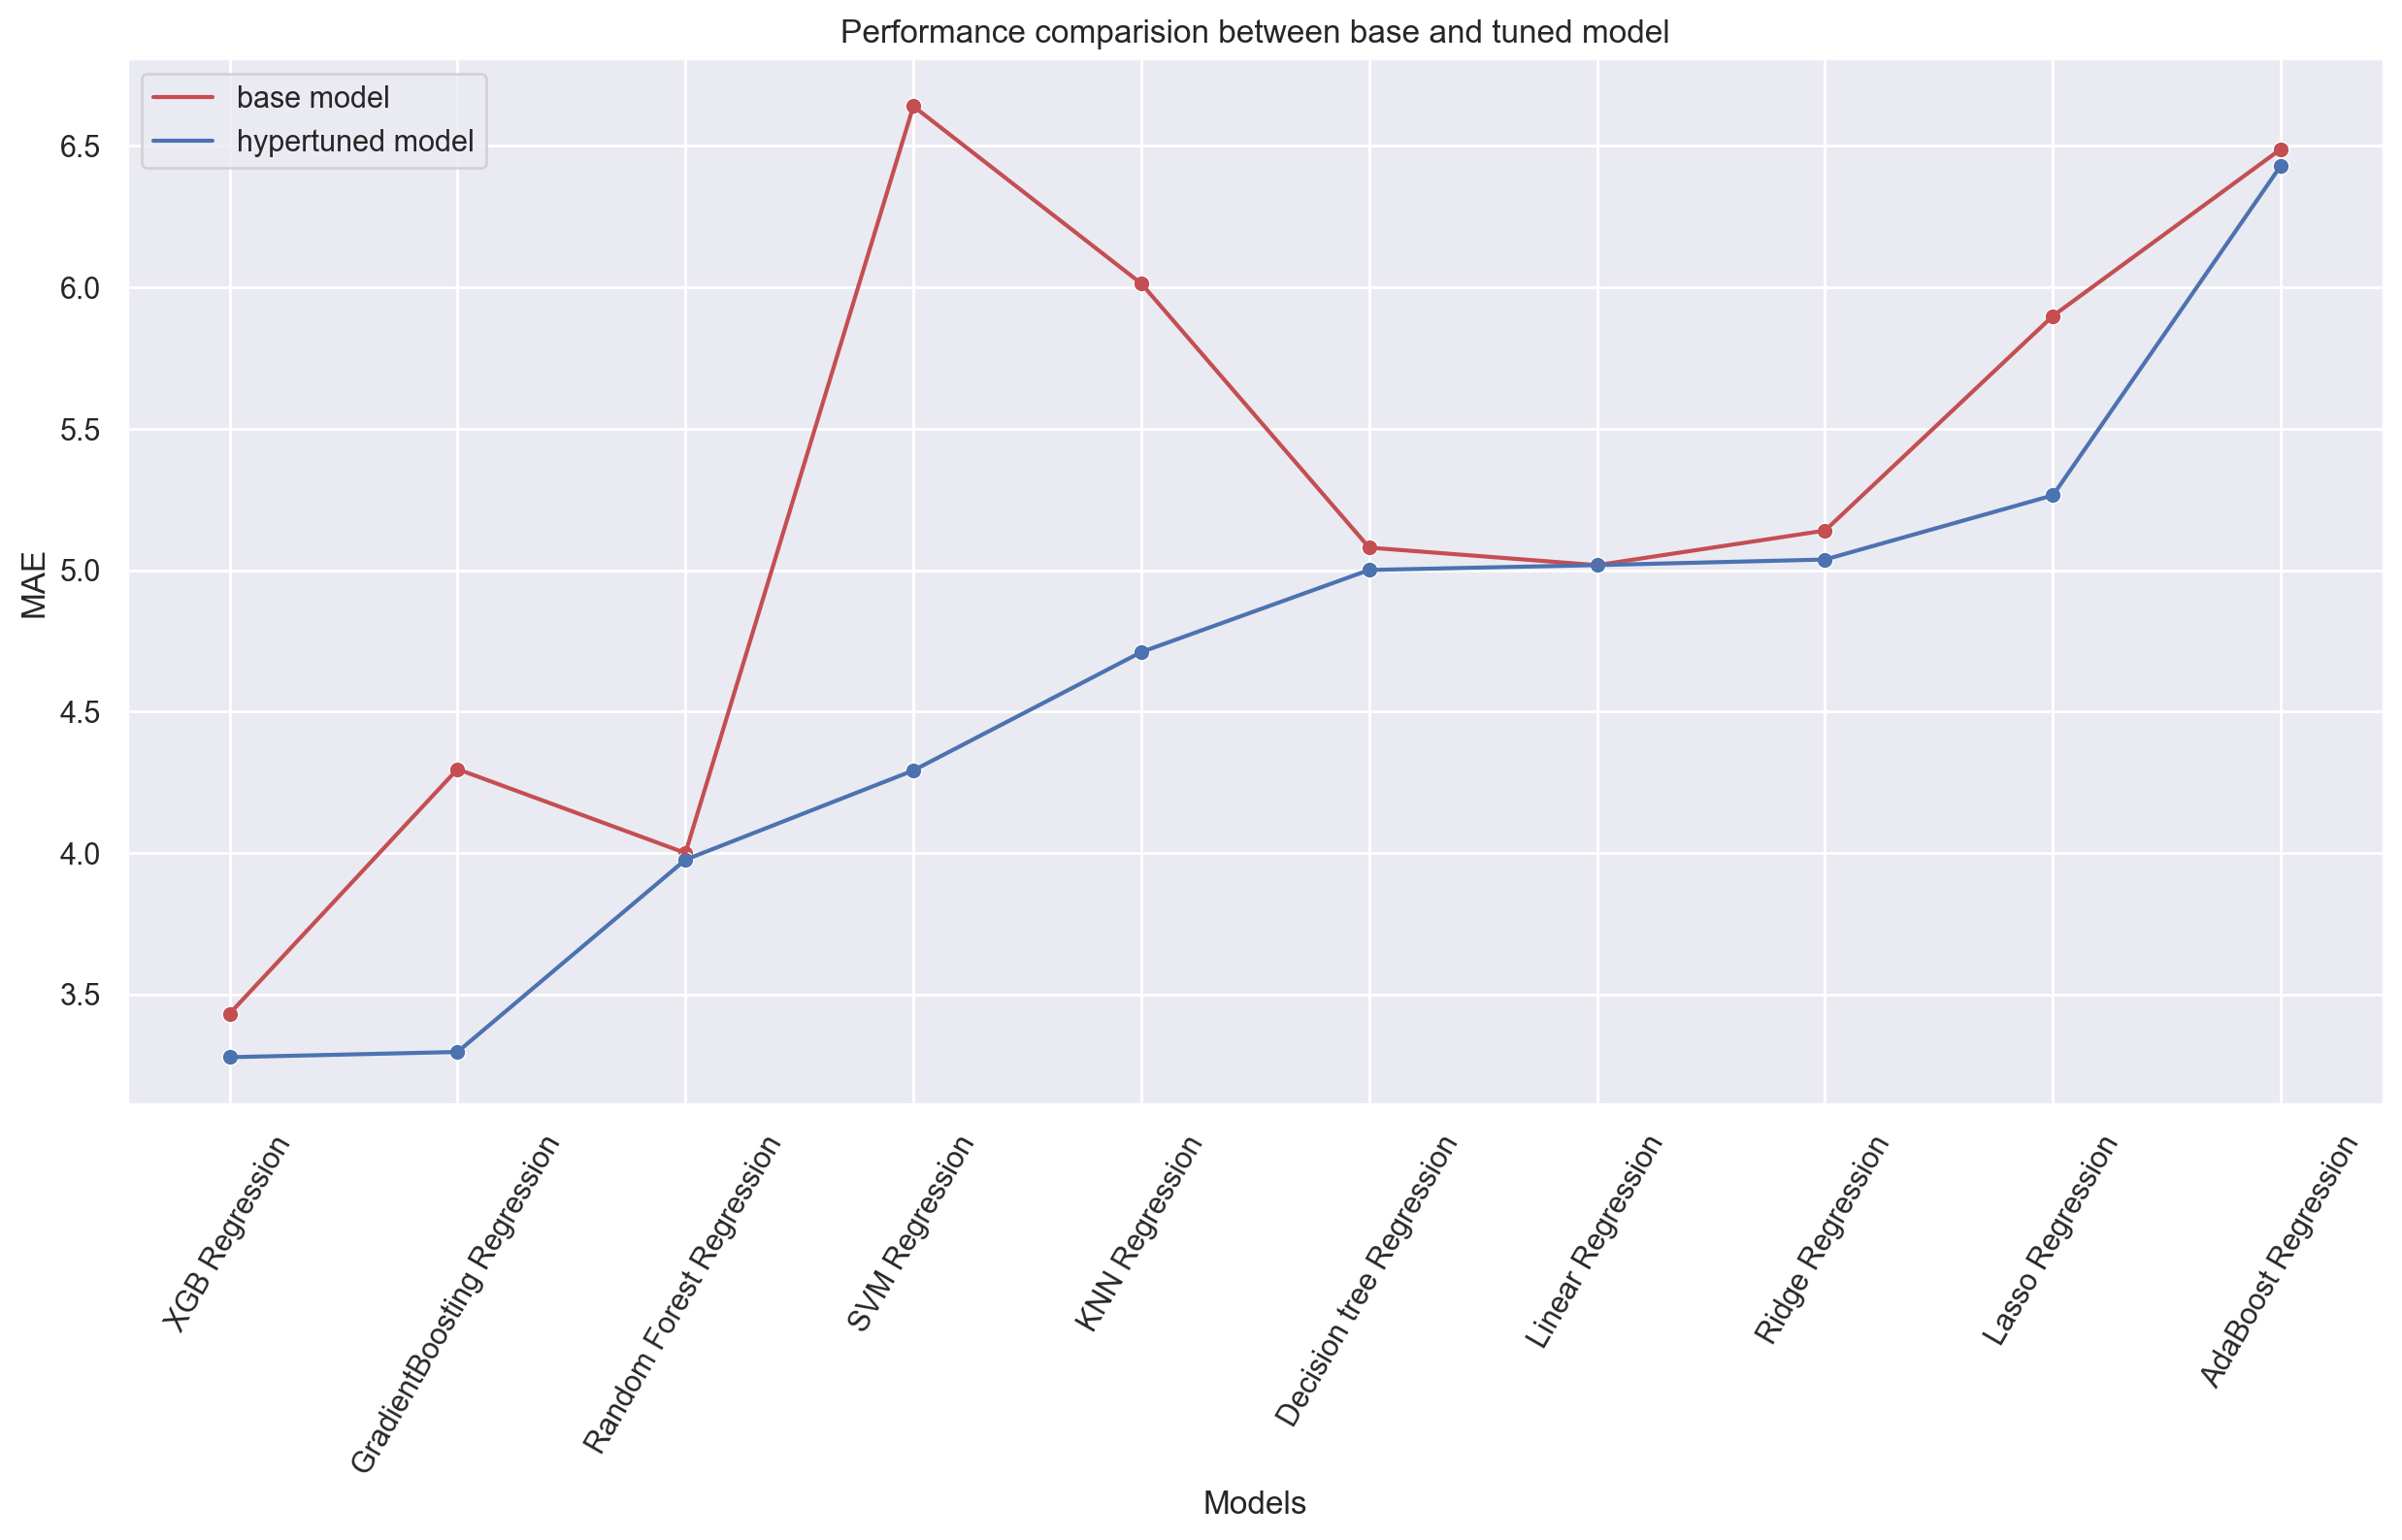

In [67]:
compare_metrics(dataframe=model_performance_df,col = 'mae')

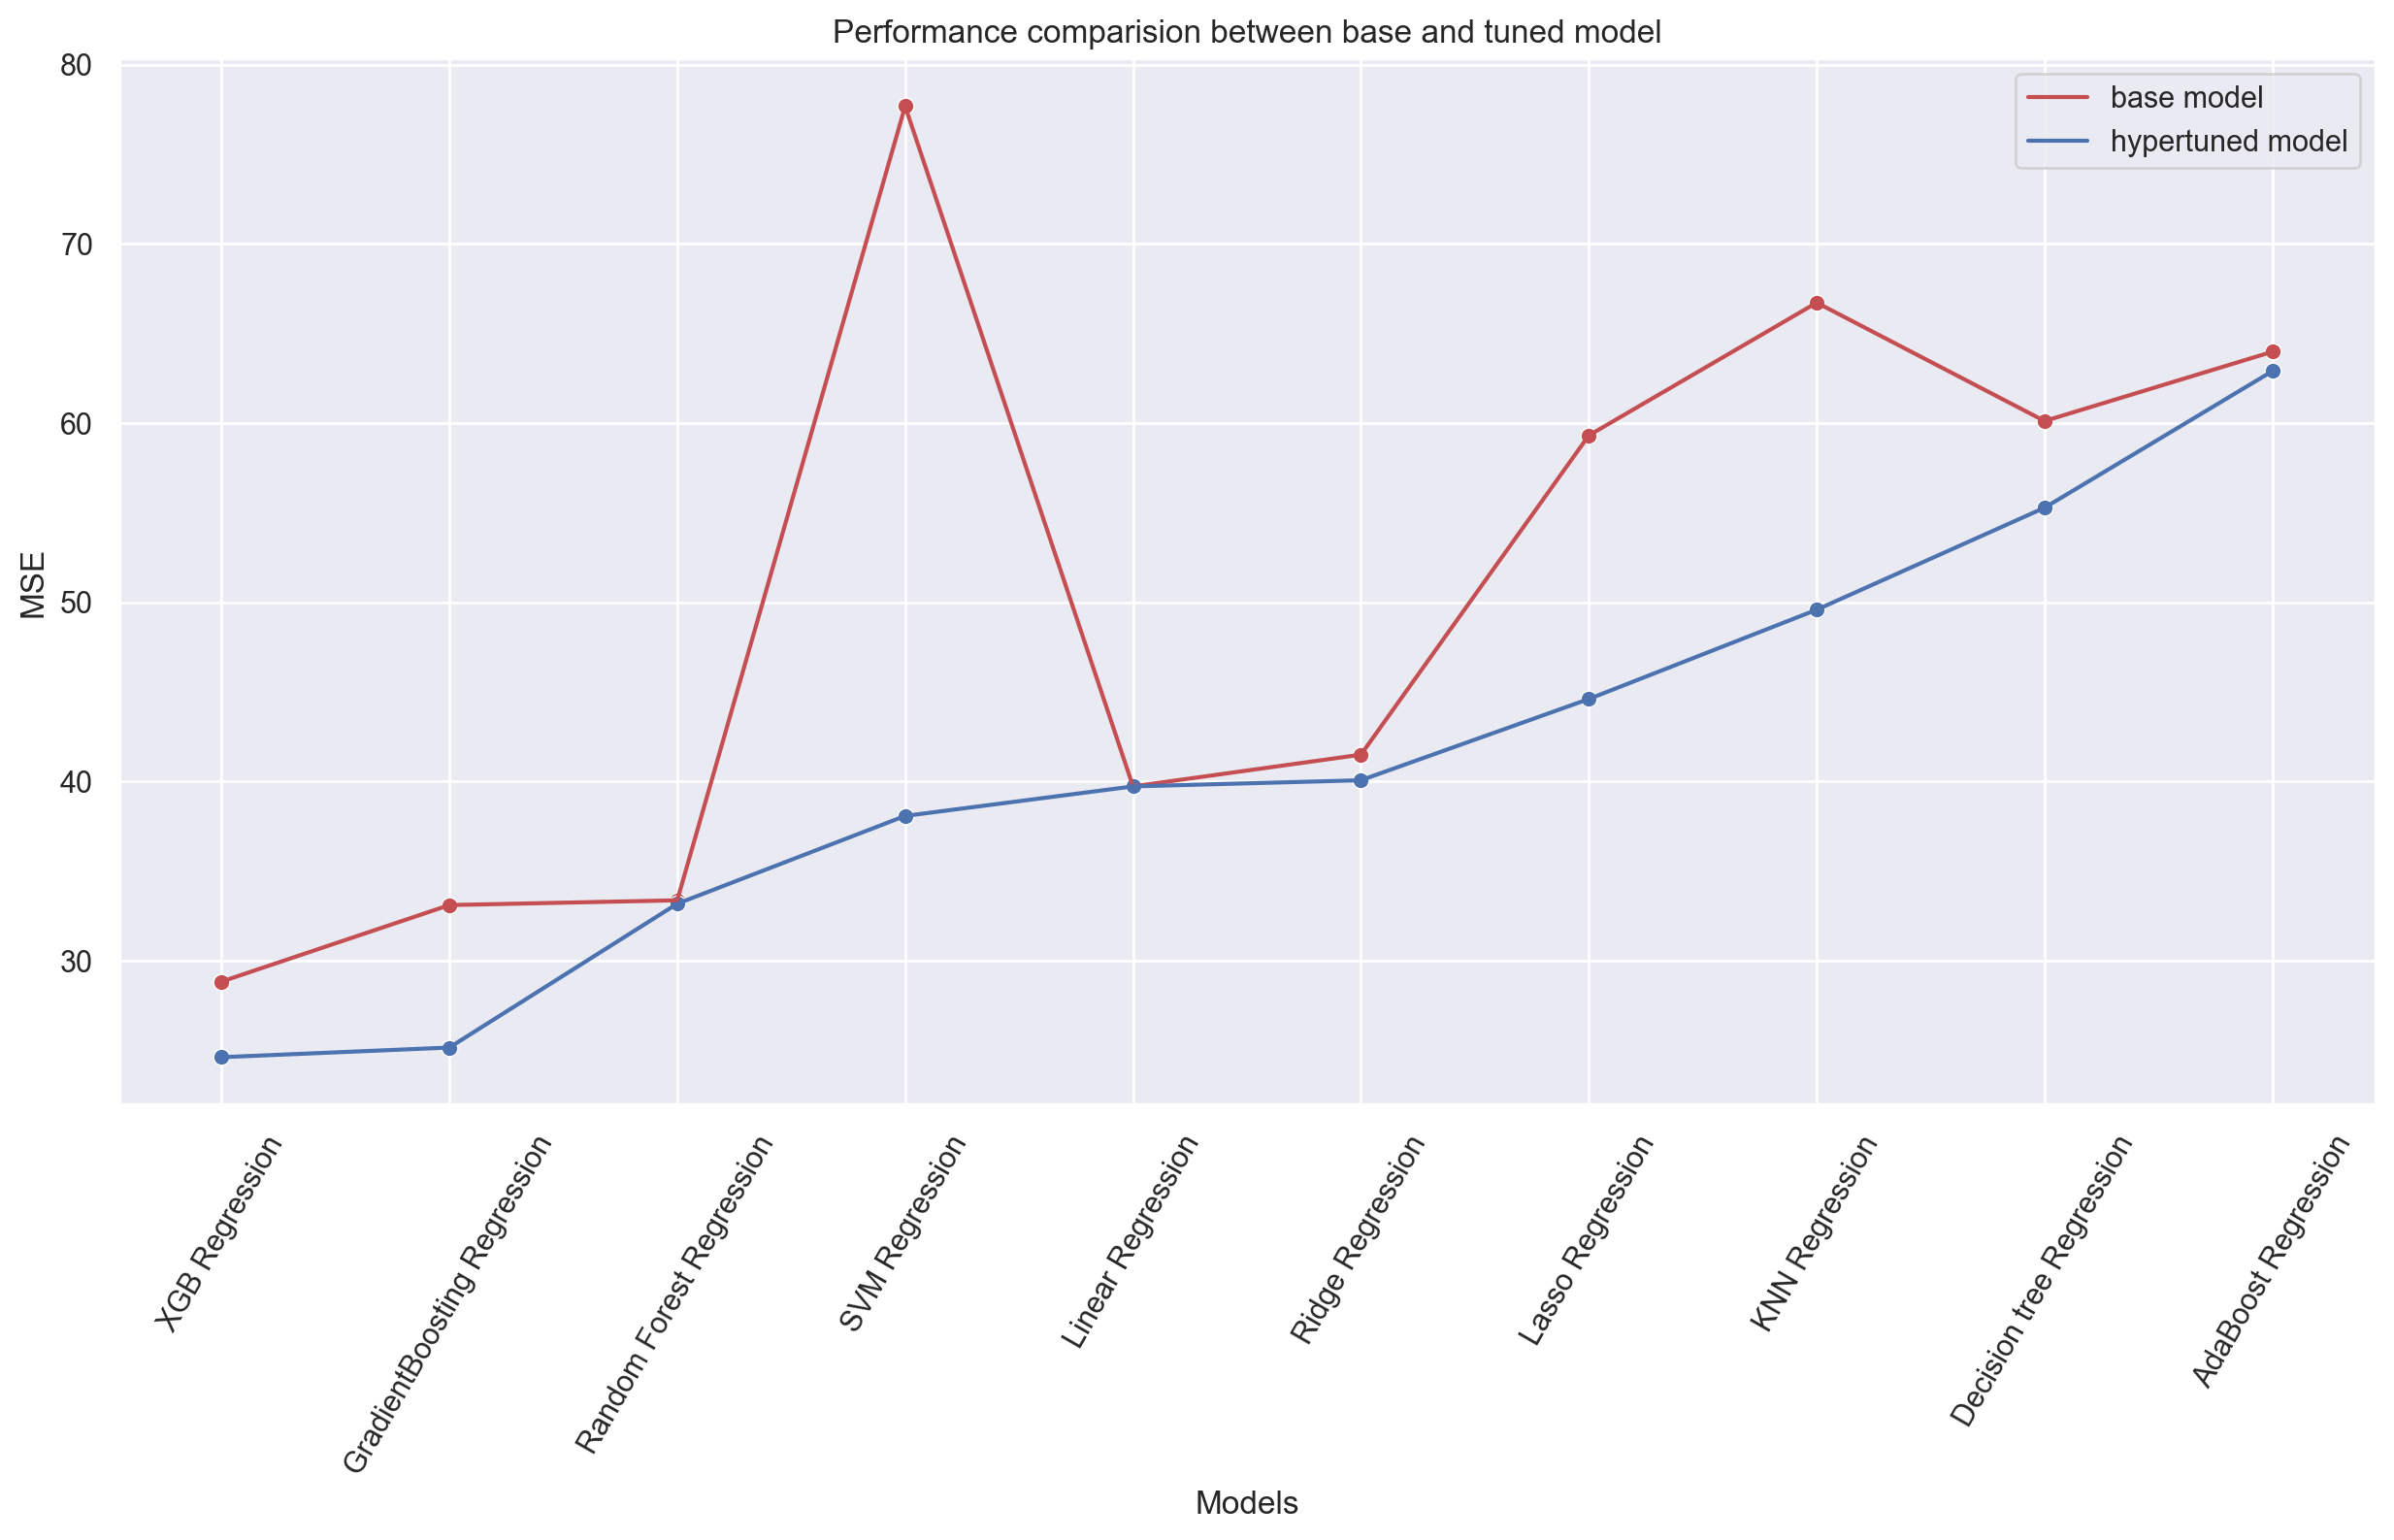

In [68]:
compare_metrics(dataframe=model_performance_df,col = 'mse')

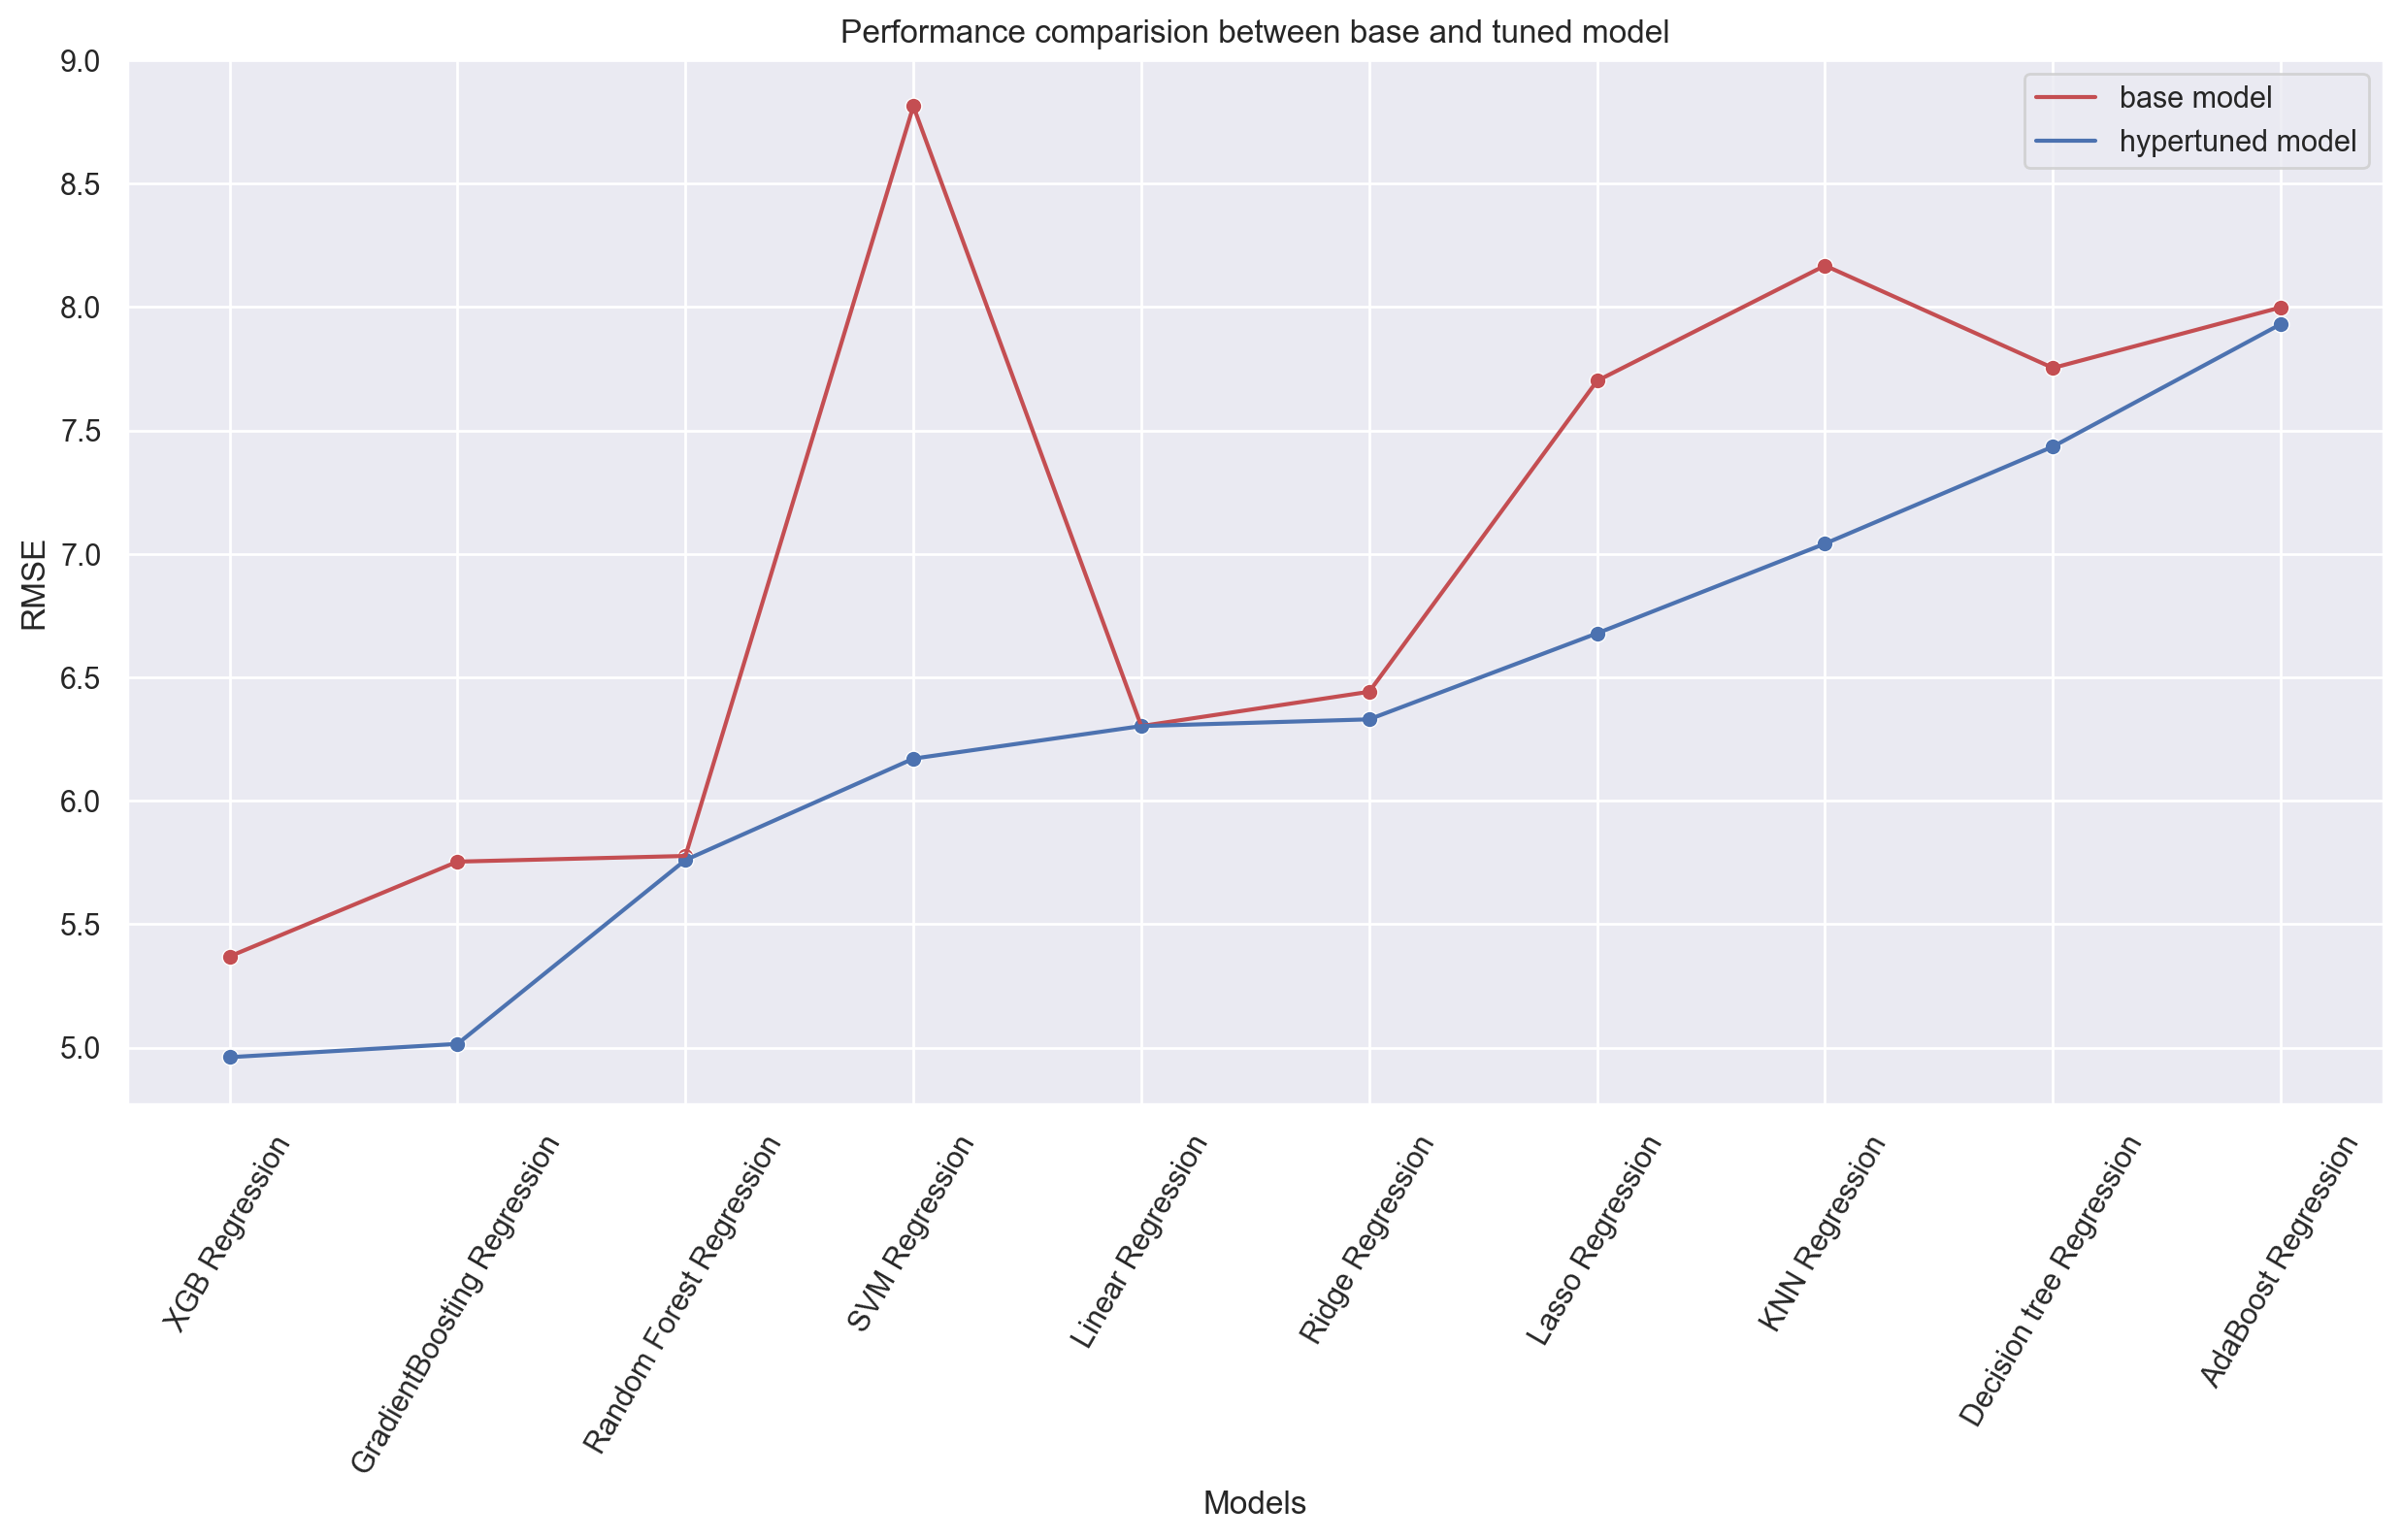

In [69]:
compare_metrics(dataframe=model_performance_df,col = 'rmse')

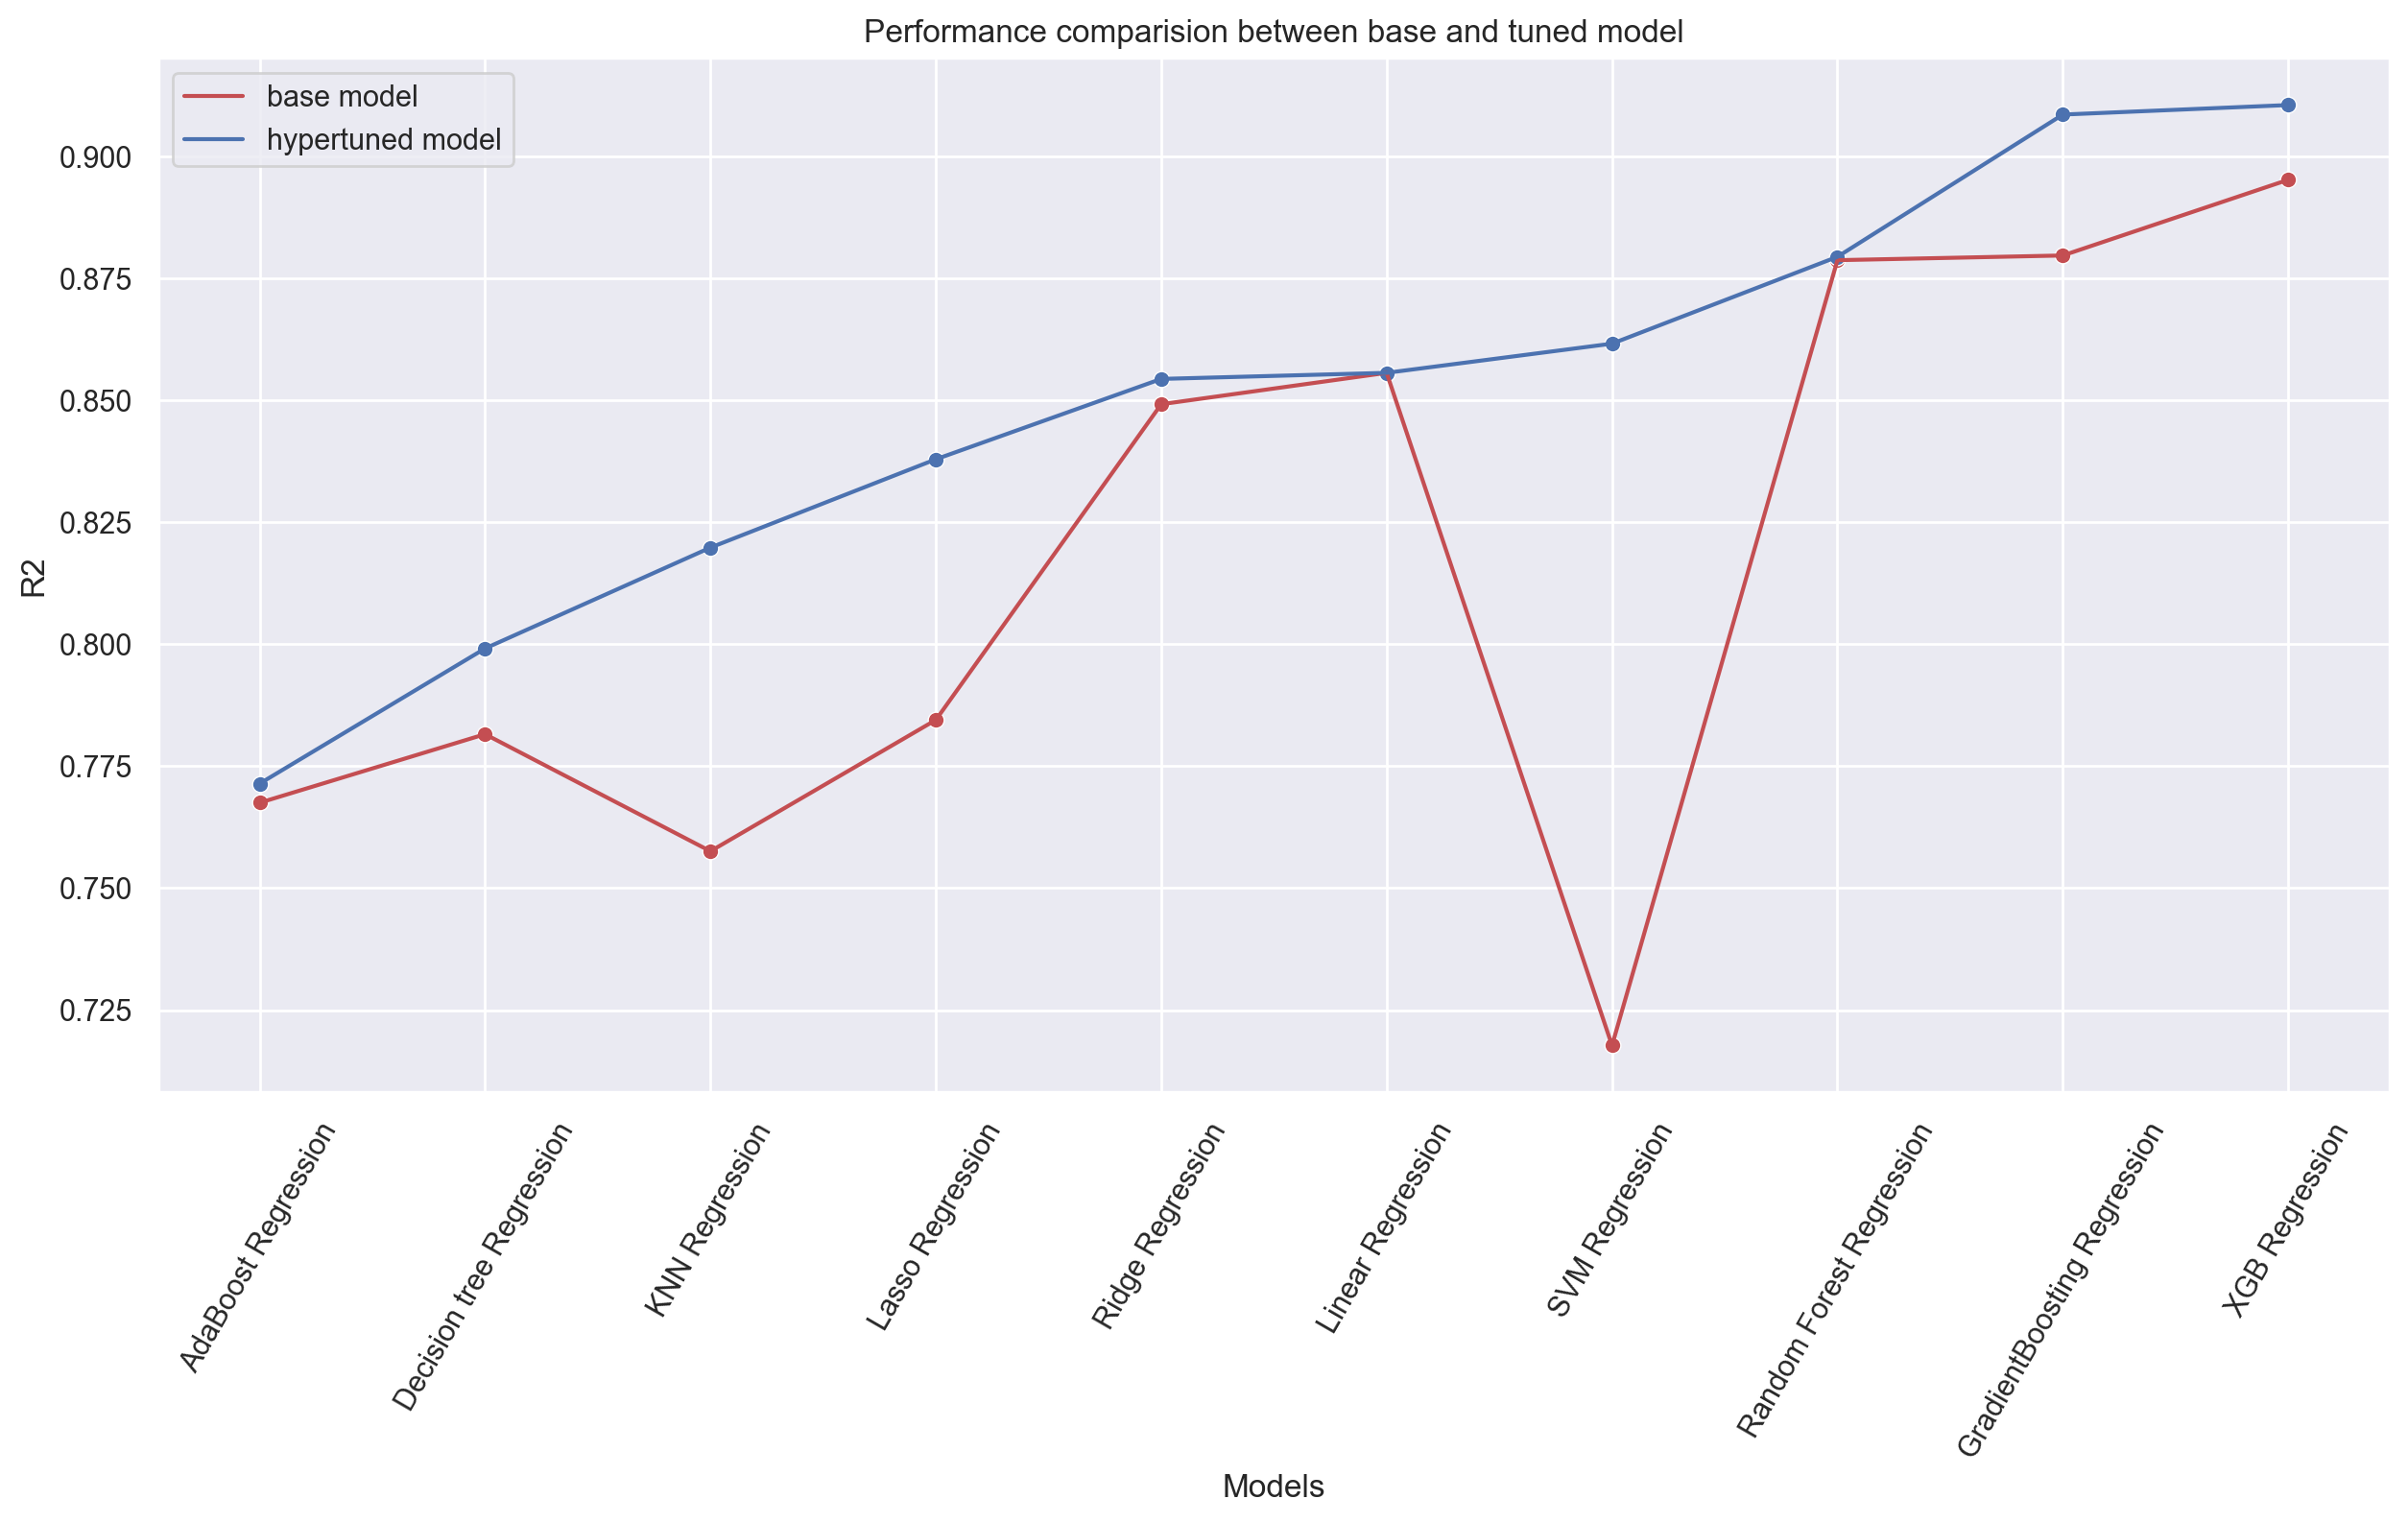

In [70]:
compare_metrics(dataframe=model_performance_df,col = 'r2')

In [93]:
model = model_performance_df[model_performance_df['model_name_base'] == 'XGB Regression'][['model']]['model'].values[0]

In [86]:
with open('models/model.pkl', 'wb') as file:
    pickle.dump(model,file)

In [95]:
pred = model.predict(test_X)

Text(0.5, 1.0, 'Scatter plot between prediction and true values')

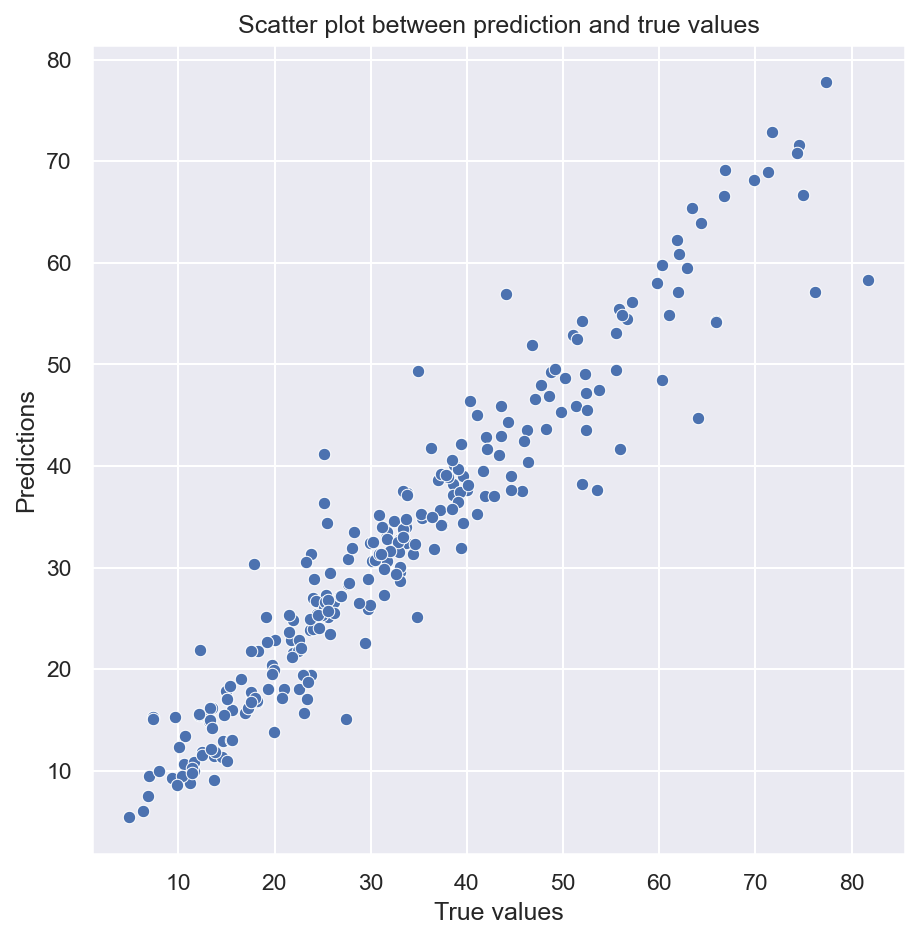

In [101]:
plt.figure(figsize=(7,7),dpi = 150)
sns.scatterplot(x = test_y,y = pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Scatter plot between prediction and true values')